In [231]:
import pandas as pd
data = {'id':[1,2,2,3],
        'company':['stackoverflow', 'crunchbase', 'stackoverflow', 'stackoverflow'],
        'bank':['bezos', 'mayfield', 'andreessen', 'bezos'], 
        'round': ['series c', 'series b', 'series d', 'series d'], 'funding': [10, 18, 40, 40],
        'date': ['2013-06-01', '2017-04-01', '2015-01-01', '2015-01-01']}
df = pd.DataFrame(data, columns = ['id','company', 'bank', 'round', 'funding', 'date'])
print df

   id        company        bank     round  funding        date
0   1  stackoverflow       bezos  series c       10  2013-06-01
1   2     crunchbase    mayfield  series b       18  2017-04-01
2   2  stackoverflow  andreessen  series d       40  2015-01-01
3   3  stackoverflow       bezos  series d       40  2015-01-01


In [ ]:
            company         round0       bank0   funding0         date0     round1   bank1                funding1       date1 
0     stackoverflow      series c        bezos         10    2013-06-01   series a   [andreessen, bezos]        40  2015-01-01
1        crunchbase      series b     mayfield         18    2017-04-01       None   None                     None        None

In [234]:
import pandas as pd
data = {'id':[1,2,2,3],'company':[1,2,2,1],'bank':['a', 'x', 'y', 'a'], 
    'round': ['seed', 'seed', 'seed', 'series a'], 'funding': [100, 200, 200, 300],
   'date': ['2006-12-01', '2004-09-01', '2004-09-01', '2007-05-01']}
df = pd.DataFrame(data, columns = ['id','company', 'round', 'bank', 'funding', 'date'])
df

,id,company,round,bank,funding,date
0,1,1,seed,a,100,2006-12-01
1,2,2,seed,x,200,2004-09-01
2,2,2,seed,y,200,2004-09-01
3,3,1,series a,a,300,2007-05-01


# Crunchbase EDA by Mitchell

I'd be careful running some of this code as it might take awhile. Given what features I'm given, I'd like to see how founders impact the success or failure of a company as well as the financing institution. Currently, I'm tackling this problem from two different angles. The first angle is combining three databases into one then cleaning up duplicates that need some information put into the proper index row. The second angle is combining two databases for the financial organizations and faces the same issue as the founder dataframe.
I'm thinking a random forest will perform well on this dataset. And, to compare this to a type of artificial neural network. My hypothesis is that the ANN will have a better accuracy but at the cost of time. I'd also be interested to see if some sort of time series linear regression might provide predictability to when a start up needs its next round of financing.

The biggest risk is how to clean up this data. I'm doing some feature engineering to group degrees, institutions among other things but that will be introducing my own bias. The biggest bias thus far is combining degrees; I might change how granular this is. I've also narrowed down my founders dataframe where my SQL query had anything with "found" in it which also includes a lot of unique "founding member of the board" and other titles like it. Yet, I think this might also expand the scope of early important members of a company.

I'd like to accurately predict success at 80% given what data I have. I think this might be a slight stretch as to what variables I have and the fact its user generated data. Some of the things not measured (nor measurable given this dataset) is the individual's drive nor the overall market condition's acceptibility to provide financing for particular verticals. 

Additionally, I've found that AngelList allows you download a csv file of 100 results from a search. I could use this to see how my model does on post-2013 data (the CrunchBase data is pre-2013). I've already downloaded some of these results although they categorize their industries differently. Thus I've searched under several industries and some of those may overlap. I hope to get to this point though!

In [13]:
#!pip install MySQL-python

    100% |████████████████████████████████| 112kB 1.7MB/s ta 0:00:01
  Running setup.py bdist_wheel for MySQL-python ... - \ | / - \ done
  Stored in directory: /Users/anniebarry/Library/Caches/pip/wheels/38/a3/89/ec87e092cfb38450fc91a62562055231deb0049a029054dc62
Successfully built MySQL-python


In [1]:
import MySQLdb
import numpy as np
import pandas as pd
import scipy.stats as stats
import Levenshtein

import csv

import matplotlib.pyplot as plt
import seaborn as sns

# plt.style('fivethirtyeight')

# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline

# this line makes plots prettier on mac retina screens. If you don't have one it shouldn't do anything.
%config InlineBackend.figure_format = 'retina'

dsn = "mysql://root@localhost:3306/crunchbase"
conn = MySQLdb.connect(host="127.0.0.1", user="root", db="crunchbase")
tables = pd.read_sql("SHOW TABLES", con=conn)
tables

,Tables_in_crunchbase
0,cb_acquisitions
1,cb_degrees
2,cb_funding_rounds
3,cb_funds
4,cb_investments
5,cb_ipos
6,cb_milestones
7,cb_objects
8,cb_offices
9,cb_people


In [2]:
founder_string = """
SELECT r.person_object_id, p.first_name, p.last_name, p.affiliation_name, p.birthplace, 
d.degree_type, d.subject, d.institution, d.graduated_at, 
r.relationship_object_id, r.title, r.start_at, r.end_at, r.is_past
FROM cb_people as p
INNER JOIN cb_relationships as r
ON  p.object_id = r.person_object_id
INNER JOIN cb_degrees as d 
ON p.object_id = d.object_id
WHERE r.title LIKE '%found%'
"""

df_founder = pd.read_sql(founder_string, con=conn)

In [99]:
df_founder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48325 entries, 0 to 48324
Data columns (total 19 columns):
person_object_id          48325 non-null object
first_name                48325 non-null object
last_name                 48325 non-null object
affiliation_name          48325 non-null object
birthplace                48325 non-null object
degree_type               48325 non-null object
subject                   48325 non-null object
institution               48325 non-null object
graduated_at              31148 non-null datetime64[ns]
relationship_object_id    48325 non-null object
title                     48325 non-null object
start_at                  30408 non-null datetime64[ns]
end_at                    10912 non-null datetime64[ns]
is_past                   48325 non-null int64
grad_year                 31148 non-null float64
grad_month                31148 non-null float64
grad_day                  31148 non-null float64
start_year                30408 non-null float64


In [3]:
def cleaning_string_data():
    
    for column in df_founder.columns:
        if (column != "end_at" and
            column != "is_past" and
            column != "start_at" and 
            column != "graduated_at" and
            column != "person_object_id" and 
            column != "relationship_object_id"):
                    df_founder[column] = ["no " + column + " declared" if col == None 
                                          else col for col in df_founder[column]]
                    df_founder[column] = df_founder[column].str.lower()
                    df_founder[column] = df_founder[column].map(lambda x: x.replace('.',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace(')',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace('(',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace(',',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace('and',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace('&',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace('/', ' '))
        
    return df_founder[column]


df_founder['graduated_at'] = pd.to_datetime(pd.Series(df_founder['graduated_at']))
df_founder['start_at'] = pd.to_datetime(pd.Series(df_founder['start_at']))
df_founder['end_at'] = pd.to_datetime(pd.Series(df_founder['end_at']))

cleaning_string_data()

df_founder['grad_year'] = df_founder.graduated_at.dt.year
df_founder['grad_month'] = df_founder.graduated_at.dt.month
df_founder['grad_day'] = df_founder.graduated_at.dt.day
df_founder['start_year'] = df_founder.start_at.dt.year
df_founder['end_year'] = df_founder.end_at.dt.year

In [92]:
# Naive bayes, LDA, NER, SVM
# word2vec: bi-grams
len(df_founder.subject.value_counts())

7612

In [93]:
df = df_founder.head(20)

In [102]:
len(df_founder.degree_type.value_counts())

2523

In [ ]:
df_founderunder.

In [98]:
df_founder[df_founder['person_object_id'] == 'p:48366']

,person_object_id,first_name,last_name,affiliation_name,birthplace,degree_type,subject,institution,graduated_at,relationship_object_id,title,start_at,end_at,is_past,grad_year,grad_month,grad_day,start_year,end_year
6624,p:48366,robert,s langer,combinent biomedical systems,albany new york usa,bs,chemical engineering,cornell university,1970-01-01,c:37981,founder,NaT,NaT,0,1970.0,1.0,1.0,NaN,NaN
6625,p:48366,robert,s langer,combinent biomedical systems,albany new york usa,scd,chemical engineering,massachusetts institute of technology mit,1974-01-01,c:37981,founder,NaT,NaT,0,1974.0,1.0,1.0,NaN,NaN
17613,p:48366,robert,s langer,combinent biomedical systems,albany new york usa,bs,chemical engineering,cornell university,1970-01-01,c:25339,founder board member,NaT,NaT,0,1970.0,1.0,1.0,NaN,NaN
17614,p:48366,robert,s langer,combinent biomedical systems,albany new york usa,scd,chemical engineering,massachusetts institute of technology mit,1974-01-01,c:25339,founder board member,NaT,NaT,0,1974.0,1.0,1.0,NaN,NaN
29457,p:48366,robert,s langer,combinent biomedical systems,albany new york usa,bs,chemical engineering,cornell university,1970-01-01,c:25836,co-founder,NaT,NaT,0,1970.0,1.0,1.0,NaN,NaN
29458,p:48366,robert,s langer,combinent biomedical systems,albany new york usa,scd,chemical engineering,massachusetts institute of technology mit,1974-01-01,c:25836,co-founder,NaT,NaT,0,1974.0,1.0,1.0,NaN,NaN
39084,p:48366,robert,s langer,combinent biomedical systems,albany new york usa,bs,chemical engineering,cornell university,1970-01-01,c:150337,founder,NaT,NaT,0,1970.0,1.0,1.0,NaN,NaN
39085,p:48366,robert,s langer,combinent biomedical systems,albany new york usa,scd,chemical engineering,massachusetts institute of technology mit,1974-01-01,c:150337,founder,NaT,NaT,0,1974.0,1.0,1.0,NaN,NaN
39086,p:48366,robert,s langer,combinent biomedical systems,albany new york usa,bs,chemical engineering,cornell university,1970-01-01,c:257904,founder,NaT,NaT,0,1970.0,1.0,1.0,NaN,NaN
39087,p:48366,robert,s langer,combinent biomedical systems,albany new york usa,scd,chemical engineering,massachusetts institute of technology mit,1974-01-01,c:257904,founder,NaT,NaT,0,1974.0,1.0,1.0,NaN,NaN


In [5]:
# company_with_founders = df_founder.groupby('relationship_object_id').agg({'person_object_id': 'count'})
founders_dates = df_founder.groupby(['person_object_id', 'institution', 'degree_type', 'subject']).agg({'grad_year': 'min', 'start_year': 'min'})
founders_dates.dropna(inplace=True)
founders_dates.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16467 entries, (p:100031, gogte institute of technology, bs, information science  engineering) to (p:99997, university of ottawa, ba, communications)
Data columns (total 2 columns):
start_year    16467 non-null float64
grad_year     16467 non-null float64
dtypes: float64(2)
memory usage: 694.6+ KB


In [10]:
colleges = {
    # cleaned label: [candidate list]
    "stanford": ["stanford university", "stanford university graduate school of business", 
                 "stanford university medical school"],
    "harvard": ["harvard business school", "harvard university", "harvard law school"],
    "cornell": ["cornell university"],
    "berkeley": ["university of california, berkeley", 
                 "university of california, berkeley, walter a. haas school of business"],
    "mit": ["massachusetts institute of technology (mit)", "mit", "massachusetts institute of technology"],
    "upenn": ["university of pennsylvania", "the wharton school of the university of pennsylvania", 
              "university of pennsylvania - the wharton school"],
    "yale": ["yale", "yale university", "yale school of management"],
    "umi": ["university of michigan", "ross school of business"],
    "mi_st": ["michigan state university"],
    "columbia": ["columbia university", "columbia", "columbia university, business school"],
    "princeton": ["princeton", "princeton university"],
    "dartmouth": ["dartmouth college", "dartmouth", "tuck school of business"],
    "ucla": ["university of california, los angeles (ucla)", "university of california, los angeles"],
    "uchicago": ["university of chicago", "booth school of management"],
    "carnegie_mellon": ["carnegie mellon university"],
    "duke": ["duke university", "fuqua school of business"],
    "brown": ["brown university"],
    "israel": ["tel aviv university", "technion-machon technologi le' israel", "the hebrew university"],
    "boston_u": ["boston university"],
    "uwash": ["university of washington"],
    "oxford": ["university of oxford"],
    "uvirginia": ["university of virginia"],
    "santa clara": ["santa clara university"],
    "u_s_cali": ["university of southern california (usc)", "university of southern california"],
    "ucsb": ["university of california, santa barbara (ucsb)"],
    "cambridge": ["university of cambridge"],
    "georgetown": ["georgetown university"],
    "nyu": ["new york university (nyu)", "new york university"],
    "u_il_urbana": ["university of illinois at urbana-champaign"],
    "purdue": ["purdue university"],
    "u_wi_madison": ["university of wisconsin-madison"],
    "san_jose_state_u": ["san jose state university"],
    "boston_c": ["boston college"],
    "byu": ["brigham young university"],
    "ut_austin": ["the university of texas at austin", "university of texas at austin"],
    "tufts": ["tufts university"],
    "notre_dame": ["university of notre dame"],
    "mcgill": ["mcgill university"],
    "babson": ["babson college"],
    "canada": ["university of toronto", "university of british columbia", 
               "university of melbourne", "university of waterloo"],
    "az_st_u": ["arizona state university"],
    "u_il": ["university of illinois"],
    "northwestern": ["northwestern university", "northwestern university, kellogg school of management"],
    "northeastern:": ["northeastern university"],
    "ga_tech": ["georgia institute of technology"],
    "syracuse": ["syracuse university"],
    "uc_davis": ["university of california, davis (ucd)"],
    "uc_sd": ["university of california, san diego (ucsd)"],
    "u_az": ["university of arizona"],
    "uco_boulder": ["university of colorado at boulder"],
    "penn_st": ["pennsylvania state university"],
    "oh_st": ["ohio state university"],
    "lse": ["london school of economics and political science"],
    "cal_tech": ["california institute of technology"],
    "rice": ["rice university"],
    "va_tech": ["virginia tech"],
    "texas_am": ["texas a&m university"],
    "u_md": ["university of maryland"],
    "uc_irvine": ["university of california, irvine"],
    "mispelled": ["universit", "insead"]
}


def levenshtein_map_school(school):
    
    if school == None:    
        return school
    
    for label, candidates in colleges.items():
        
        for candidate in candidates:
        
            ratio = Levenshtein.ratio(school.decode("utf8").encode("utf8"), candidate)
            if ratio >= .96:
                
                return label
                # print u"school: %s could match: %s " % (label, candidate)
     
    return school

df_founder['canonical_school'] = df_founder.institution.map(levenshtein_map_school)



In [200]:
degrees = {
    # cleaned label: [candidate list]
    "bachelor": ["bs", "ba", "be", "bba", "btech", "bfa", "bcom", "beng", "bachelor", 
                 "bachelor of arts (ba)", "bachelor of science (bs)", "basc", "bsc", "bcs", 
                 "bsme", "bachelor of business administration", "bachelor of applied science", "bachelors",
                "bachelor of fine arts", "bachelor of technology (btech)", "scb", "ba, bs", "barch", "ba with honours",
                "ba with honors", "bmus", "bmath"],
    "mba": ["mba", "master of business administration", "amp", "management", "opm"],
    "masters": ["ms", "mse", "meng", "mfa", "mphil", "master degree", "me", "mpa", "mph", "mps",
                "master", "master of engineering", "sm", "msc", "edm", "master of science (msc)", "mpp",
               "entrepreneurial masters program", "master of philosophy", "exchange (master)"],
    "law": ["jd", "llb", "llm", "law", "doctor of law (jd)", "master of laws (llm)"],
    "phd": ["phd", "doctor of philosophy (phd)"],
    "md": ["md", "scd", "dsc", "doctor of medicine (md)", "medical degree"],
    "associate": ["aa", "as", "aas", "associates of science"],
    "bachelor/master": ["bs/ms"],
    "graduated_other": ["diploma", "degree", "certificate", "graduation", "graduated", "high school", "post graduate",
                       "undergrad", "undergraduate degree", "graduate diploma", "certification", "hsc",
                       "college diploma", "licence"],
    "engineering_other": ["engineer", "engineering", "computer science", "dipl-ing", "bs electrical engineering",
                         "electrical engineering"],
    "post_doc": ["fellowship", "post-doctoral"],
    "executive_training": ["executive education", "executive program", "executive certificate", 
                           "executive education program"],
    "incomplete": ["incomplete", "n/a", "none"]
}


def levenshtein_map_degrees(degree):
    
    if degree == None:    
        return degree
    
    for label, candidates in degrees.items():
        
        for candidate in candidates:
        
            ratio = Levenshtein.ratio(degree.decode("utf8").encode("utf8"), candidate)
            if ratio >= .7:
                
                return label
                # print u"school: %s could match: %s " % (label, candidate)
     
    return degree

df_founder['canonical_degree'] = df_founder.degree_type.map(levenshtein_map_degrees)


In [15]:
df_founder.institution.value_counts()

stanford university                                     1683
university of california berkeley                        864
harvard university                                       830
massachusetts institute of technology mit                760
harvard business school                                  721
cornell university                                       535
university of pennsylvania                               492
universit                                                478
university of michigan                                   466
yale university                                          412
columbia university                                      383
tel aviv university                                      366
duke university                                          358
carnegie mellon university                               356
stanford university graduate school of business          352
university of california los angeles ucla                292
university of southern c

In [198]:
subjects = {
    # cleaned label: [candidate list]
    "cs": ["computer science", "computer engineering", "information technology", "software engineering",
          "information systems", "management information systems", "computer sciences", "computer", "informatics",
           "computer science & engineering", "systems engineering", "it", "artificial intelligence", 
          "symbolic systems", "computer information systems", "computer software engineering", "computing",
          "information science", "information management"],
    "business": ["economics", "finance", "business", "marketing", "business administration", "mba", "management", 
                 "business management", "advertising", "international business", "accounting", "general management", 
                 "international management", "business administration and management general", "marketing finance",
                "entrepreneurship", "finance and marketing", "commerce", "business economics", "economics finance",
                 "entrepreneurship/entrepreneurial studies", "finance general", "business studies", 
                 "finance and economics", "business marketing", "international finance", "finance, marketing"],
    "engineering": ["electrical engineering", "mechanical engineering", "engineering", "civil engineering",
                   "industrial engineering", "chemical engineering", "electronics engineering", "bioengineering",
                    "aerospace engineering", "biomedical engineering", "electronics engineering", "ee", 
                    "nuclear engineering"],
    "liberal_arts": ["philosophy", "history", "sociology", "psychology", "english", "political science", "film",
                     "communications", "international relations", "english literature", "journalism", "government", 
                     "anthropology", "music","fine arts", "public policy", "liberal arts", "american studies", 
                     "politics", "creative writing", "education", "arts"],
    "math/physics": ["mathematics", "physics", "applied mathematics", "statistics", "math", "theoretical physics", 
                    "applied physics", "biophysics"],
    "sciences": ["biochemistry", "neuroscience", "biology", "molecular biology", "geography", "organic chemistry",
                "cognitive science", "science", "chemistry"],
    "law": ["law", "jd", "business law"],
    "general_graduate": ["degree", "graduate", "ba", "bs"],
    "design": ["graphic design", "industrial design", "product design", "architecture", "interaction design"]
    
}


def levenshtein_map_subject(subject):
    
    if subject == None:    
        return subject
    
    for label, candidates in subjects.items():
        
        for candidate in candidates:
        
            ratio = Levenshtein.ratio(subject.decode("utf8").encode("utf8"), candidate)
            if ratio >= .9:
                
                return label
                # print u"school: %s could match: %s " % (label, candidate)
     
    return subject

df_founder['canonical_subject'] = df_founder.subject.map(levenshtein_map_subject)


2001.0

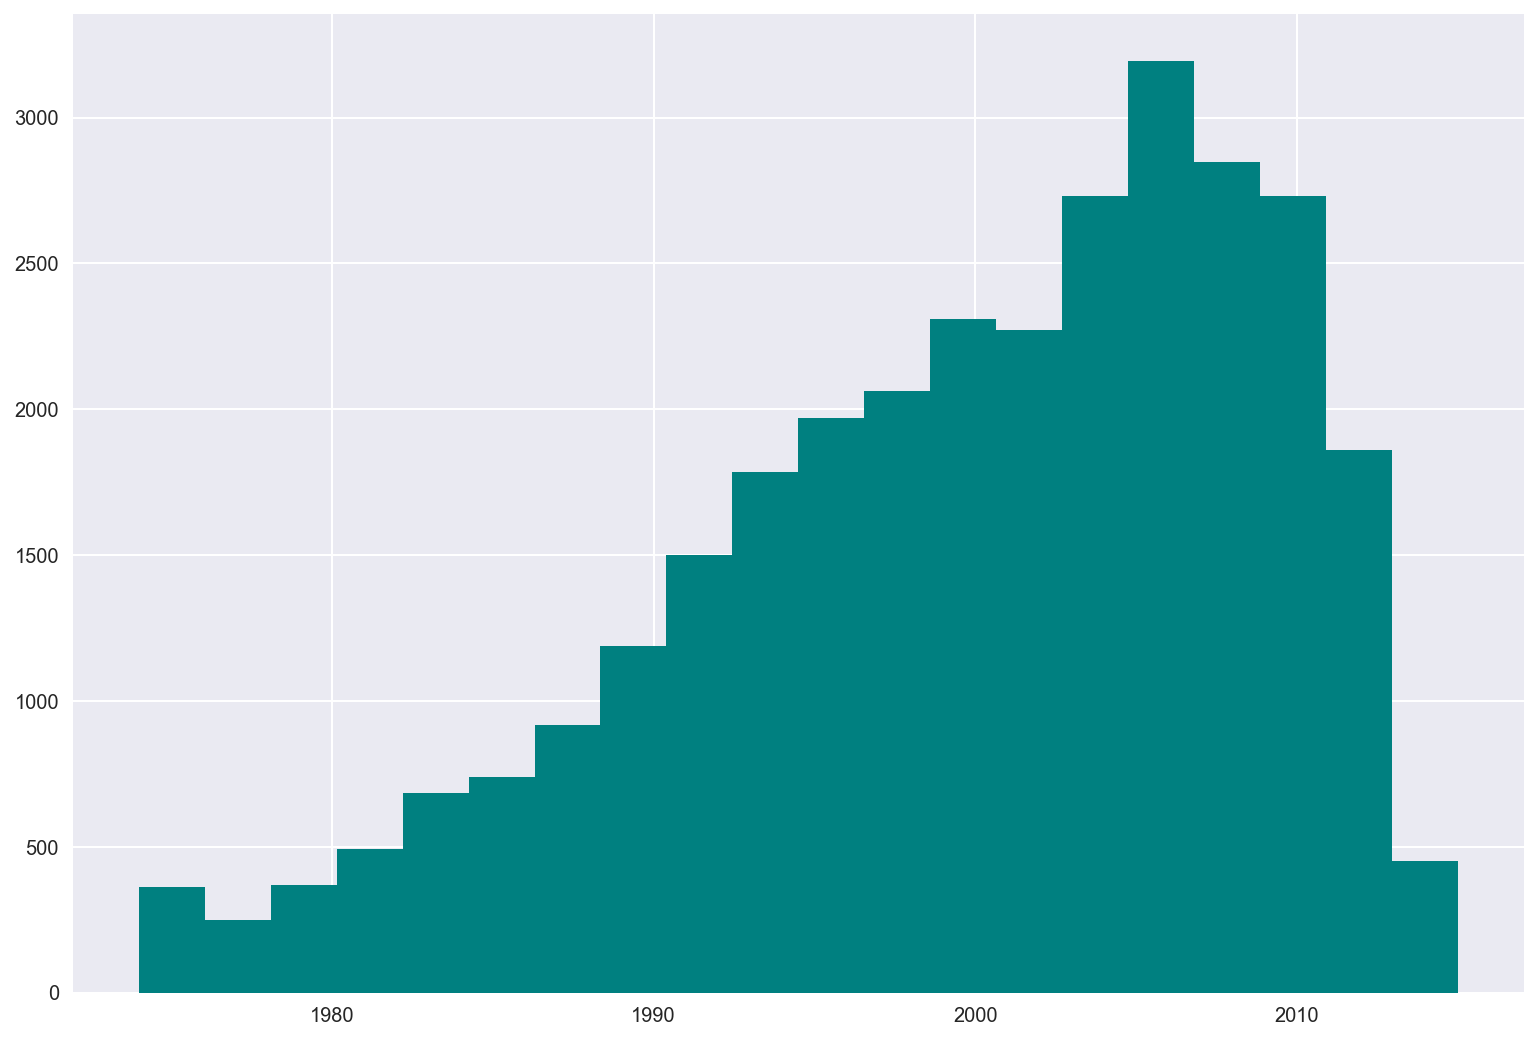

In [9]:
df_founder[df_founder['grad_year'] > 1973].grad_year.hist(bins=20, color='teal', figsize=(13,9))
df_founder.grad_year.median()

2009.0

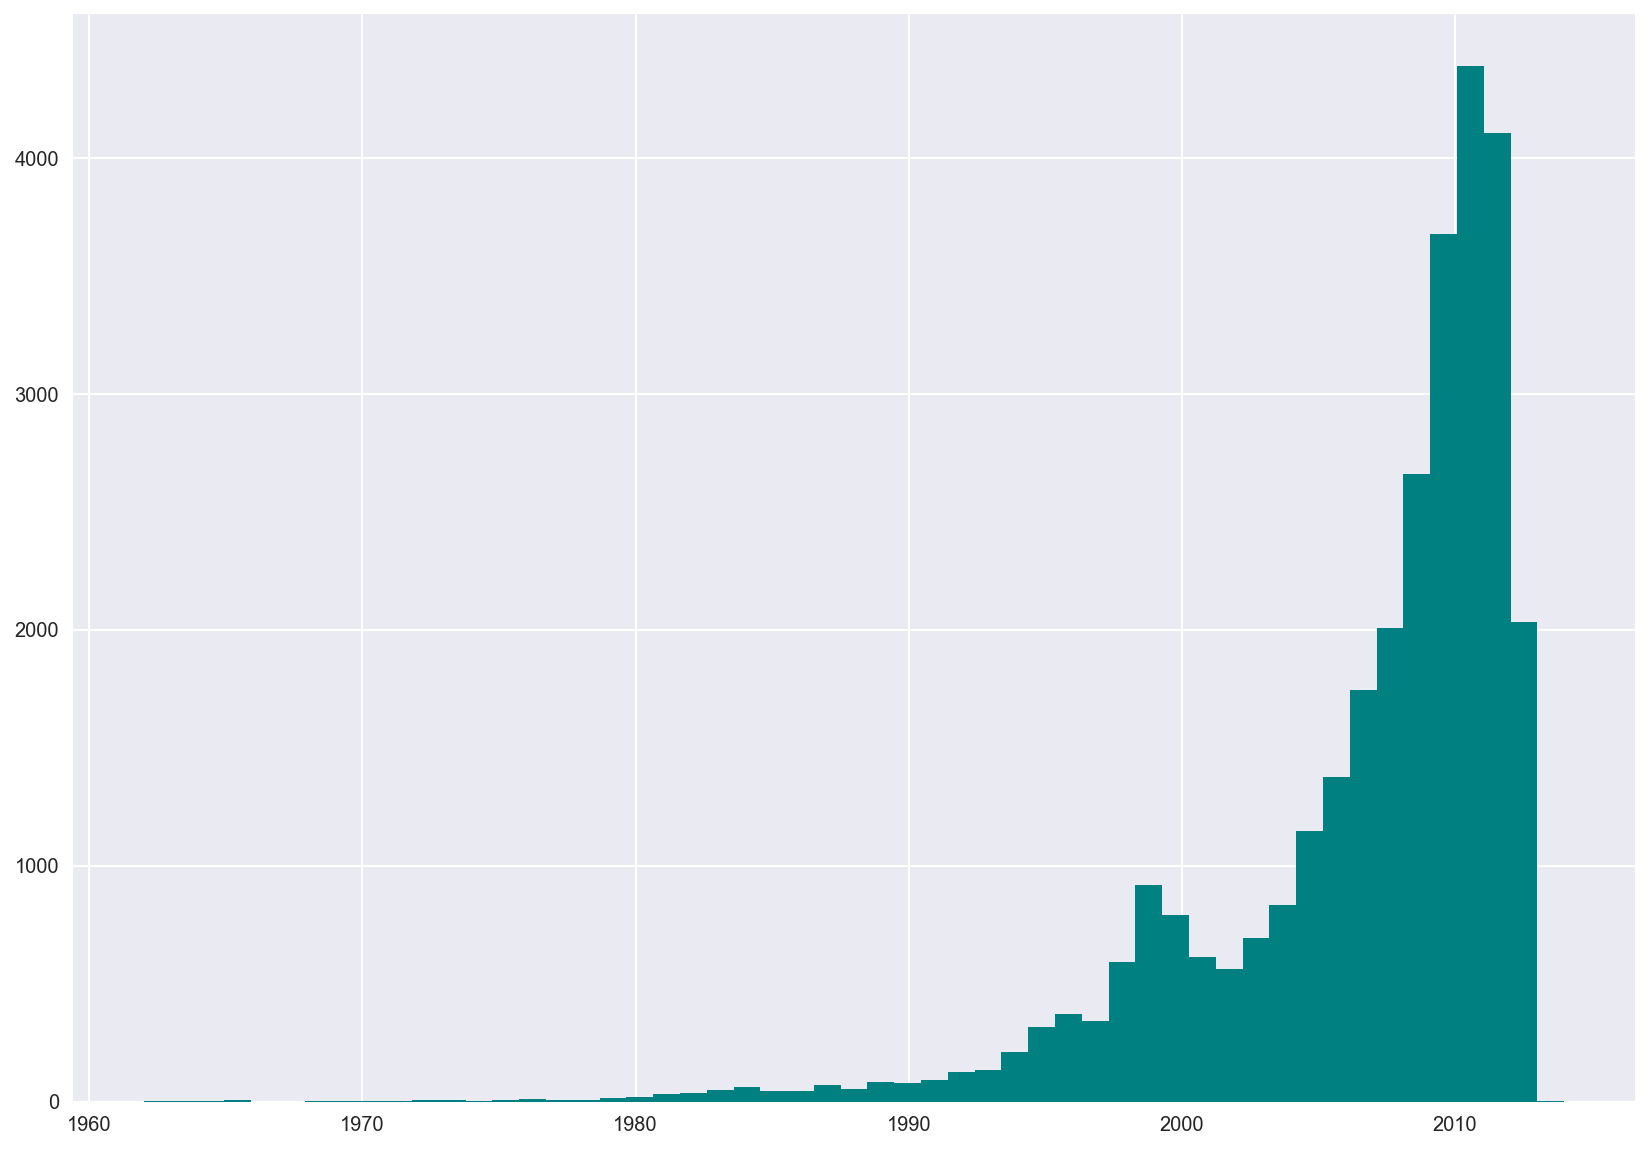

In [246]:
# df_founder[df_founder['grad_year'] > 1960].grad_year.hist(bins=55, color='teal', figsize=(13,10))

df_founder.start_year.hist(bins=53, color='teal', figsize=(14,10))
df_founder.start_year.median()

2009.0

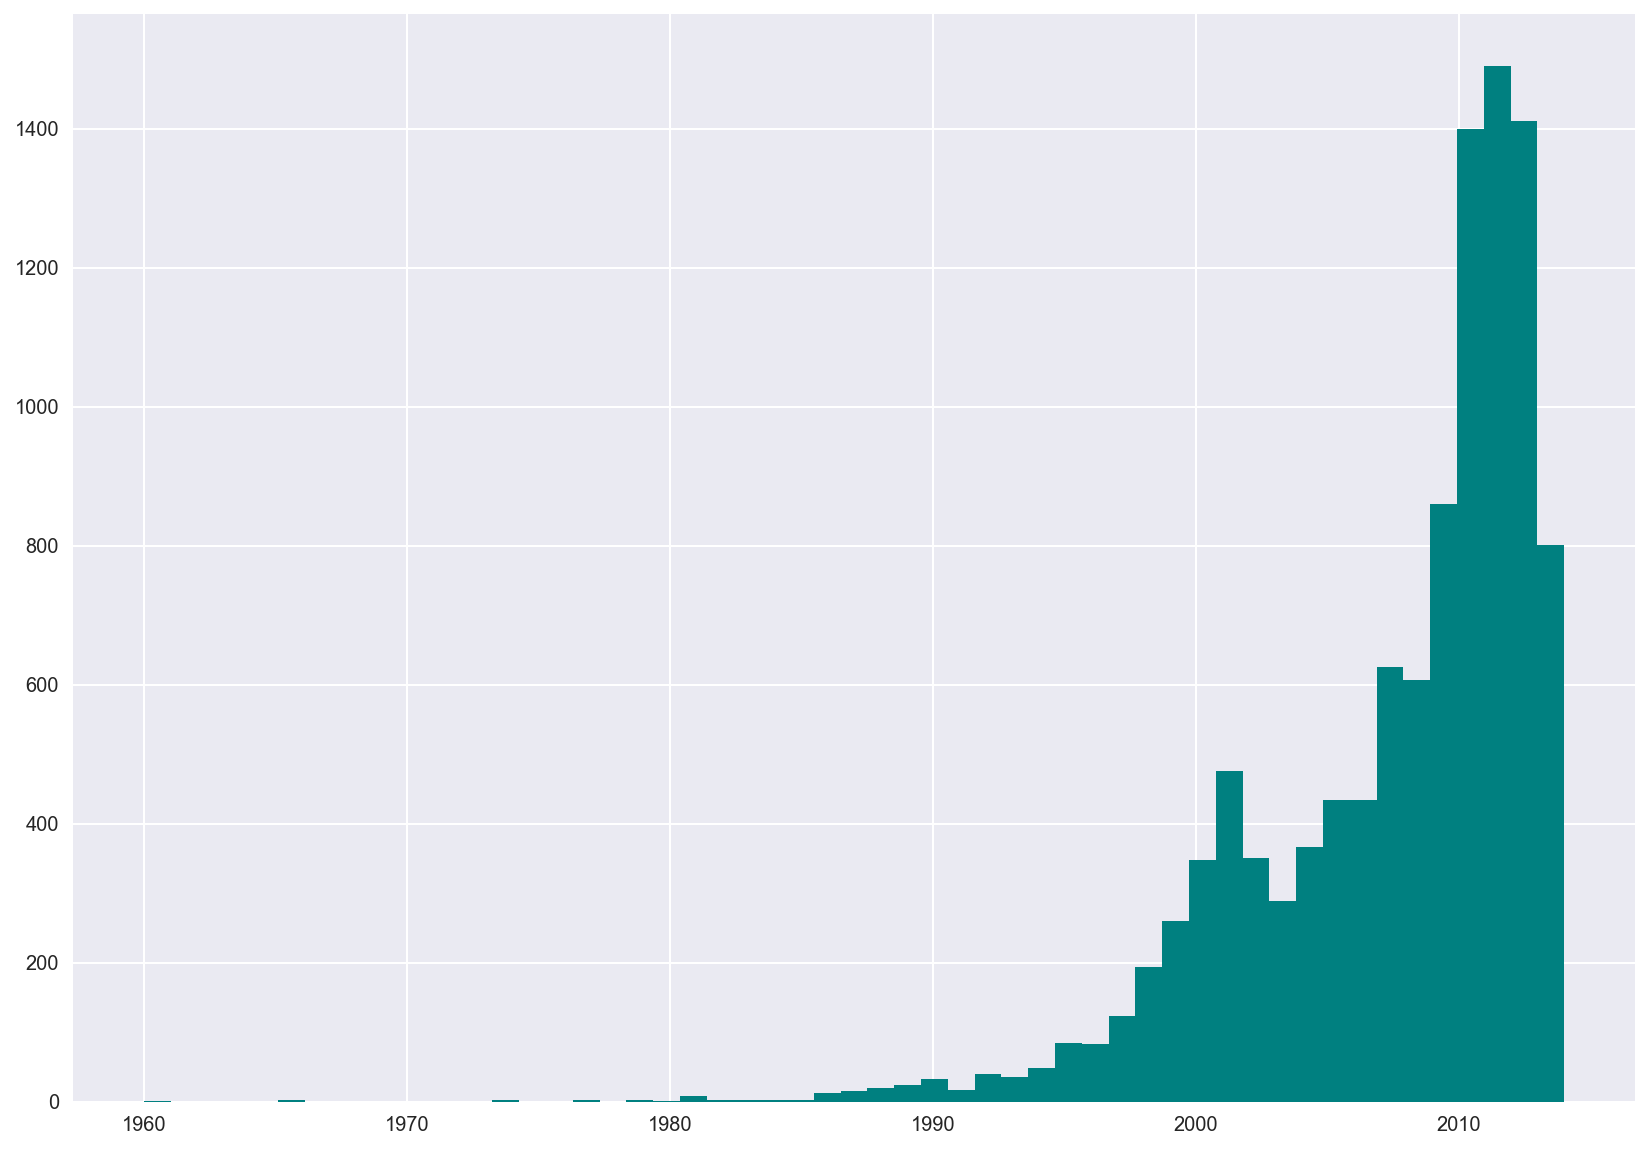

In [251]:
df_founder.end_year.hist(bins=53, color='teal', figsize=(14,10))
df_founder.end_year.median()


### Selecting Just One File

In [216]:
# What to do what to do...
df_objects = pd.read_sql("SELECT * FROM cb_objects", con=conn)
# df_acquisitions = pd.read_sql("SELECT * FROM cb_acquisitions", con=conn)
# df_ipos = pd.read_sql("SELECT * FROM cb_ipos", con=conn)

# Combined into df_funding
# df_funding_rounds = pd.read_sql("SELECT * FROM cb_funding_rounds", con=conn)
# df_investments = pd.read_sql("SELECT * FROM cb_investments", con=conn)

# Combined into df_founder
# df_people = pd.read_sql("SELECT * FROM cb_people", con=conn)
# df_relationships = pd.read_sql("SELECT * FROM cb_relationships", con=conn)
# df_degrees = pd.read_sql("SELECT * FROM cb_degrees", con=conn)


# Don't believe I'll need these...
# df_milestones = pd.read_sql("SELECT * FROM cb_milestones", con=conn)
# df_offices = pd.read_sql("SELECT * FROM cb_offices", con=conn)
# df_funds = pd.read_sql("SELECT * FROM cb_funds", con=conn)

In [7]:
df_objects["log_funding_total_usd"] = np.log1p(df_objects["funding_total_usd"])

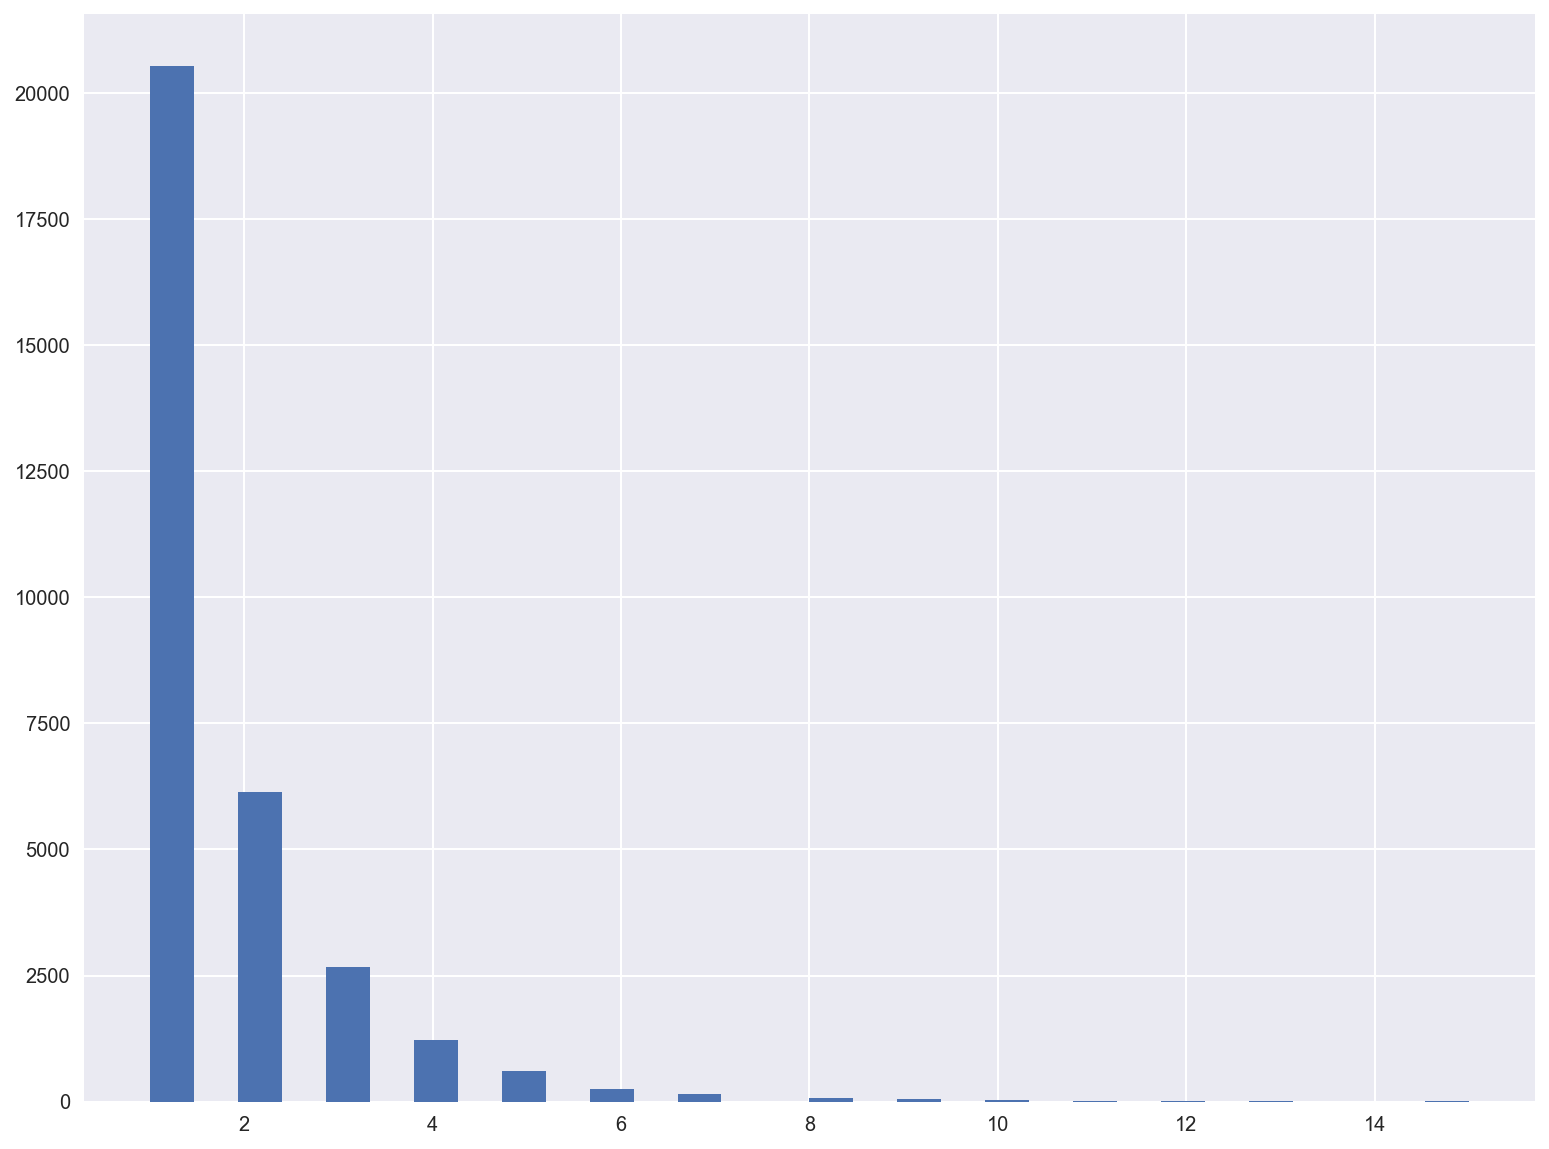

In [121]:
plt.figure(figsize=(13,10))

ax = df_objects.funding_rounds.hist(bins=30)

In [39]:
pd.DataFrame(df_objects.funding_total_usd.describe())

,funding_total_usd
count,2.787400e+04
mean,1.481652e+07
std,6.775937e+07
min,2.910000e+02
25%,5.000000e+05
50%,2.564500e+06
75%,1.100000e+07
max,5.700000e+09


In [31]:
funding_string = """
SELECT i.funding_round_id, i.investor_object_id, i.funded_object_id, 
f.raised_amount_usd, f.funded_at, f.funding_round_code, f.pre_money_valuation_usd, f.post_money_valuation_usd, 
f.participants, f.is_first_round, f.is_last_round, f.funding_round_type
FROM cb_funding_rounds as f
INNER JOIN cb_investments as i
ON f.funding_round_id = i.funding_round_id
ORDER BY i.funding_round_id
"""
df_funding = pd.read_sql(funding_string, con=conn)

In [32]:
df_funding['funded_at'] = pd.to_datetime(pd.Series(df_funding['funded_at']))
df_funding['funded_year'] = df_funding.funded_at.dt.year


In [ ]:
# df['is_lord'] = [1 if "lord" in title.lower() else 0 for title in df.title]
# finance_group.unstack()

In [77]:
my_list = ['funding_round_id', 'funded_object_id', 'raised_amount_usd', 'funded_at', 'funding_round_code_clean']
df = df_funding[my_list].head(100)

In [78]:
df = df.drop_duplicates(subset='funding_round_id')

In [ ]:
d

In [110]:
import itertools

company = df.funded_object_id.unique()
df_indexed = df.set_index(['funded_object_id', 'funding_round_code_clean'])
index = pd.MultiIndex.from_tuples(list(itertools.product(company, list(df.funding_round_code_clean.unique()))))
reindexed = df_indexed.reindex(index, fill_value=0)

reindexed = reindexed.unstack().applymap(lambda cell: 0 if '1970-01-01' in str(cell) else cell)

working_df = pd.DataFrame(reindexed.iloc[:, reindexed.columns.get_level_values(0).isin(['raised_amount_usd', 'funded_at'])].to_records())

In [136]:
working_df

,index,"('raised_amount_usd', 'a')","('raised_amount_usd', 'angel')","('raised_amount_usd', 'b')","('raised_amount_usd', 'c')","('raised_amount_usd', 'seed')","('raised_amount_usd', 'series_d_above')","('funded_at', 'a')","('funded_at', 'angel')","('funded_at', 'b')","('funded_at', 'c')","('funded_at', 'seed')","('funded_at', 'series_d_above')"
0,c:13,0.0,0.0,0.0,0.0,1500000.0,0.0,0,0,0,0,2005-12-01 00:00:00,0
1,c:14,6300000.0,0.0,0.0,0.0,0.0,0.0,2007-05-01 00:00:00,0,0,0,0,0
2,c:15,3710000.0,40000.0,0.0,0.0,12000.0,0.0,2007-06-01 00:00:00,2007-01-01 00:00:00,0,0,2006-06-01 00:00:00,0
3,c:16,13500000.0,0.0,40000000.0,0.0,0.0,0.0,2007-06-01 00:00:00,0,2007-06-01 00:00:00,0,0,0
4,c:18,0.0,0.0,5700000.0,0.0,0.0,0.0,0,0,2007-01-01 00:00:00,0,0,0
5,c:22,1500000.0,0.0,0.0,0.0,0.0,0.0,2007-06-01 00:00:00,0,0,0,0,0
6,c:23,45000000.0,0.0,0.0,0.0,0.0,0.0,2007-05-09 00:00:00,0,0,0,0,0
7,c:26,13200000.0,0.0,0.0,0.0,0.0,0.0,2005-06-01 00:00:00,0,0,0,0,0
8,c:27,3800000.0,0.0,8500000.0,7000000.0,0.0,9000000.0,2002-11-01 00:00:00,0,2003-07-01 00:00:00,2004-04-01 00:00:00,0,2007-02-01 00:00:00
9,c:30,12500000.0,0.0,0.0,0.0,0.0,0.0,2007-06-01 00:00:00,0,0,0,0,0


In [72]:
df['idx'] = df.groupby('funded_object_id').cumcount()

df_tester = df.pivot(index='funded_object_id',columns='idx')[['raised_amount_usd', 'funding_round_code_clean']]

In [134]:
df_tester

raised_amount_usd                                     \
idx                              0           1           2          3   
funded_object_id                                                        
c:13                     1500000.0         NaN         NaN        NaN   
c:14                     6300000.0         NaN         NaN        NaN   
c:15                       12000.0     40000.0   3710000.0        NaN   
c:16                    40000000.0  13500000.0         NaN        NaN   
c:18                     5700000.0         NaN         NaN        NaN   
c:22                     1500000.0         NaN         NaN        NaN   
c:23                    45000000.0         NaN         NaN        NaN   
c:26                    13200000.0         NaN         NaN        NaN   
c:27                     3800000.0   8500000.0   7000000.0  9000000.0   
c:30                    12500000.0         NaN         NaN        NaN   
c:31                    10520000.0   6500000.0         NaN        NaN   
c:34                     2500000.0   5500000.0         NaN        NaN   
c:35                     5000000.0         NaN         NaN        NaN   
c:38                     2250000.0         NaN         NaN        NaN   
c:4                      8500000.0         NaN         NaN        NaN   
c:40                    12500000.0  25000000.0         NaN        NaN   
c:43                     1000000.0         NaN         NaN        NaN   
c:44                    30000000.0   5000000.0  26000000.0        NaN   
c:46                     6000000.0  25000000.0         NaN        NaN   
c:5                       500000.0  12700000.0  27500000.0        NaN   
c:53                     6850000.0   6000000.0         NaN        NaN   
c:7299                  10500000.0         NaN         NaN        NaN   
c:9                      1500000.0  10000000.0         NaN        NaN   

                 funding_round_code_clean                               
idx                                     0      1     2               3  
funded_object_id                                                        
c:13                                 seed   None  None            None  
c:14                                    a   None  None            None  
c:15                                 seed  angel     a            None  
c:16                                    b      a  None            None  
c:18                                    b   None  None            None  
c:22                                    a   None  None            None  
c:23                                    a   None  None            None  
c:26                                    a   None  None            None  
c:27                                    a      b     c  series_d_above  
c:30                                    a   None  None            None  
c:31                                    c      b  None            None  
c:34                                    a      b  None            None  
c:35                                    a   None  None            None  
c:38                                    a   None  None            None  
c:4                                     b   None  None            None  
c:40                                    b      c  None            None  
c:43                                 seed   None  None            None  
c:44                                    c      a     b            None  
c:46                                    a      b  None            None  
c:5                                 angel      a     b            None  
c:53                                    b      a  None            None  
c:7299                                  b   None  None            None  
c:9                                     a      b  None            None

In [258]:
df.loc[df.funded_object_id == 'c:5']

,funding_round_id,investor_object_id,funded_object_id,raised_amount_usd,funded_at
2,2,p:26,c:5,500000.0,2004-09-01
3,2,p:570,c:5,500000.0,2004-09-01
4,3,p:2603,c:5,12700000.0,2005-05-01
5,3,p:570,c:5,12700000.0,2005-05-01
6,3,f:4,c:5,12700000.0,2005-05-01
7,4,f:1,c:5,27500000.0,2006-04-01
8,4,f:5,c:5,27500000.0,2006-04-01
9,4,f:6,c:5,27500000.0,2006-04-01
10,4,f:3181,c:5,27500000.0,2006-04-01


In [16]:
df.funded_object_id.unique()

array(['c:4', 'c:5', 'c:7299', 'c:9', 'c:13', 'c:14'], dtype=object)

In [18]:
companies = {}

for c_id in df.funded_object_id.unique():
    company = df.loc[df['funded_object_id'] == c_id, 'investor_object_id'].unique()[0]
    companies[c_id] = company

In [19]:
companies

{'c:13': 'f:29',
 'c:14': 'f:48',
 'c:4': 'f:1',
 'c:5': 'p:26',
 'c:7299': 'f:3',
 'c:9': 'f:6'}

In [5]:
companies = {}

for c_id in df_funding.funding_round_id.unique():
    company = df_funding.loc[df_funding['funding_round_id'] == c_id, 'funded_object_id'].unique()[0]
    companies[c_id] = company

In [6]:
raised_amounts = {}

for c_id in df_funding.funding_round_id.unique():
    raised = df_funding.loc[df_funding['funding_round_id'] == c_id, 'raised_amount_usd'].unique()[0]
    raised_amounts[c_id] = raised
    
funded_times = {}

for c_id in df_funding.funding_round_id.unique():
    funded_at = df_funding.loc[df_funding['funding_round_id'] == c_id, 'funded_at'].unique()[0]
    funded_times[c_id] = funded_at

In [7]:
investor_dummies = pd.get_dummies(df_funding['investor_object_id'])

In [8]:
dummies_ids = pd.concat([df_funding.funding_round_id, investor_dummies], axis=1)

In [9]:
df_grouped = dummies_ids.groupby('funding_round_id').sum()

In [10]:
df_grouped['company'] = companies.values()
df_grouped['amount_raised'] = raised_amounts.values()
df_grouped['time_funded'] = funded_times.values()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "//anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "//anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "//anaconda/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "//anaconda/lib/python2.7/inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "//anaconda/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "//anaconda/lib/python2.7/inspect.py", line 490, in getmodule
    if is

IndexError: string index out of range

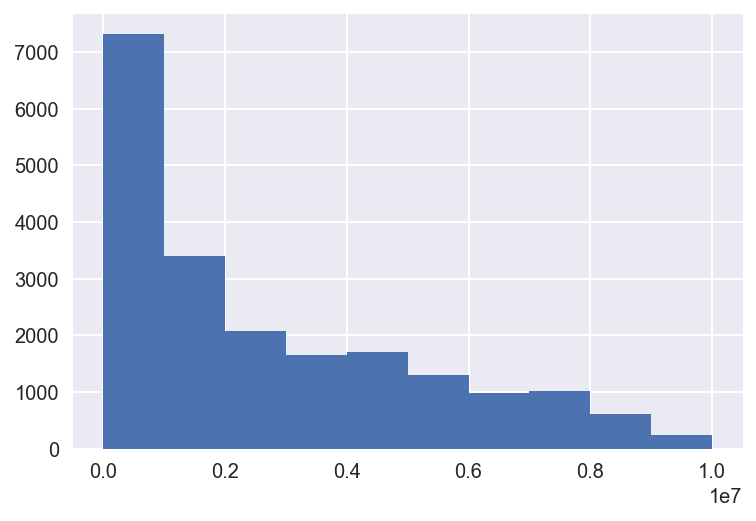

In [11]:
df_grouped[df_grouped['amount_raised'] < 10000000].amount_raised.hist()

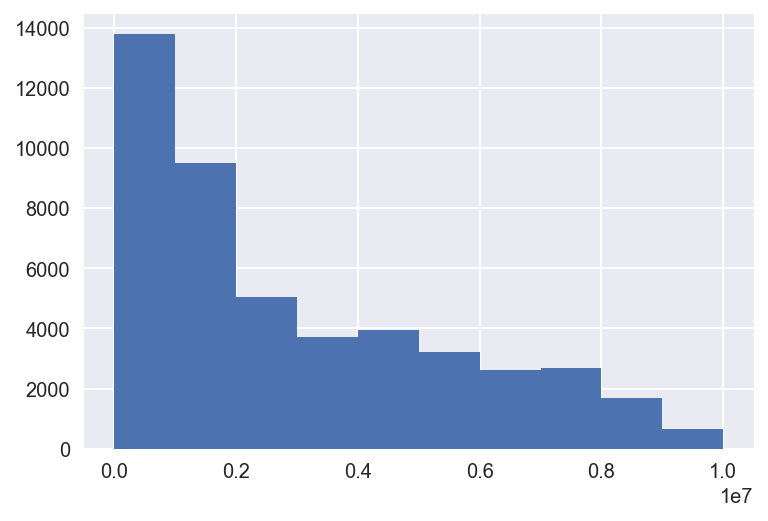

In [12]:
df_funding[df_funding['raised_amount_usd'] < 10000000].raised_amount_usd.hist()

In [175]:
new_df = df[['funding_round_id', 'investor_object_id']]

In [107]:
tuples = list(zip(*[['c:1', 'c:1', 'c:2', 'c:2',
                      'c:3', 'c:3', 'c:4', 'c:4'],
                     ['one', 'two', 'one', 'three',
                      'one', 'two', 'one', 'two']]))

index = pd.MultiIndex.from_tuples(tuples, names=['company', 'investor'])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=['A', 'B'])
df2 = df[:4]
df

A         B
company investor                    
c:1     one      -1.683318  0.357000
        two      -0.138108  0.317968
c:2     one       0.658973 -0.252993
        three     0.792206  0.893766
c:3     one       1.284731 -0.415121
        two       1.559069  0.226119
c:4     one       0.111103  0.870267
        two       0.996056 -1.110906

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128552cd0>]], dtype=object)

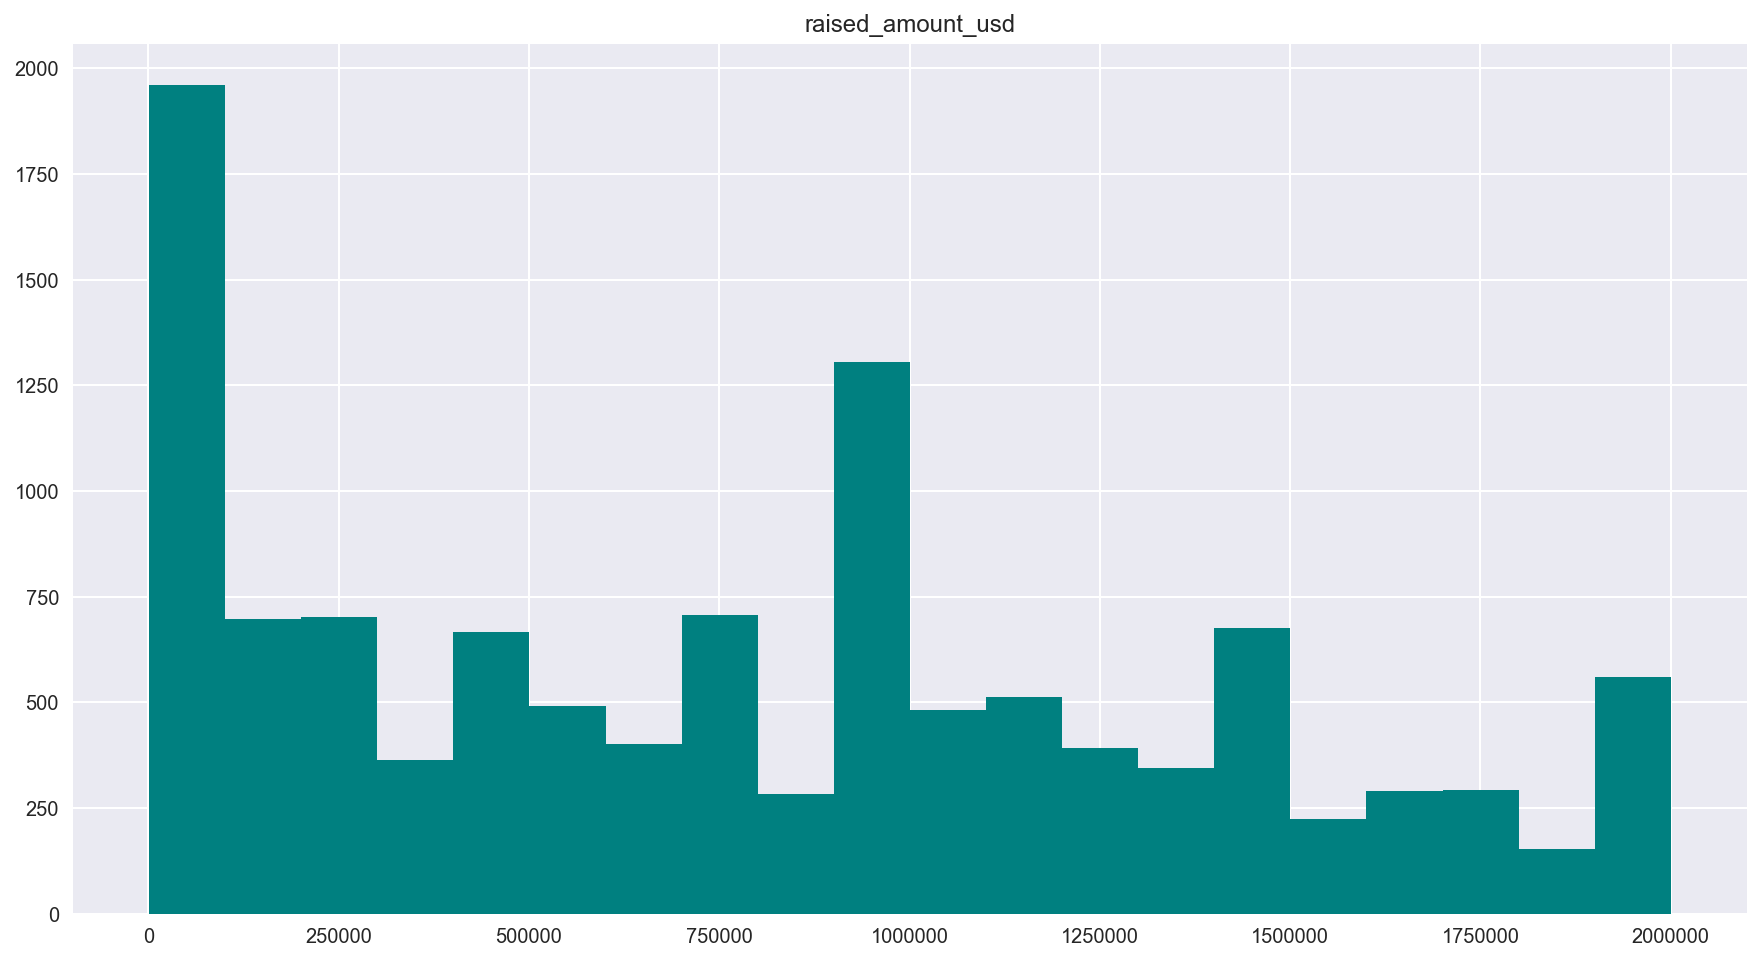

In [108]:
df_funding[(df_funding['funding_round_code'] == 'seed') &
           (df_funding['raised_amount_usd'] <= 2000000)].hist(column='raised_amount_usd', 
                                                               bins=20, 
                                                               color='teal',
                                                              figsize=(15,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127d663d0>]], dtype=object)

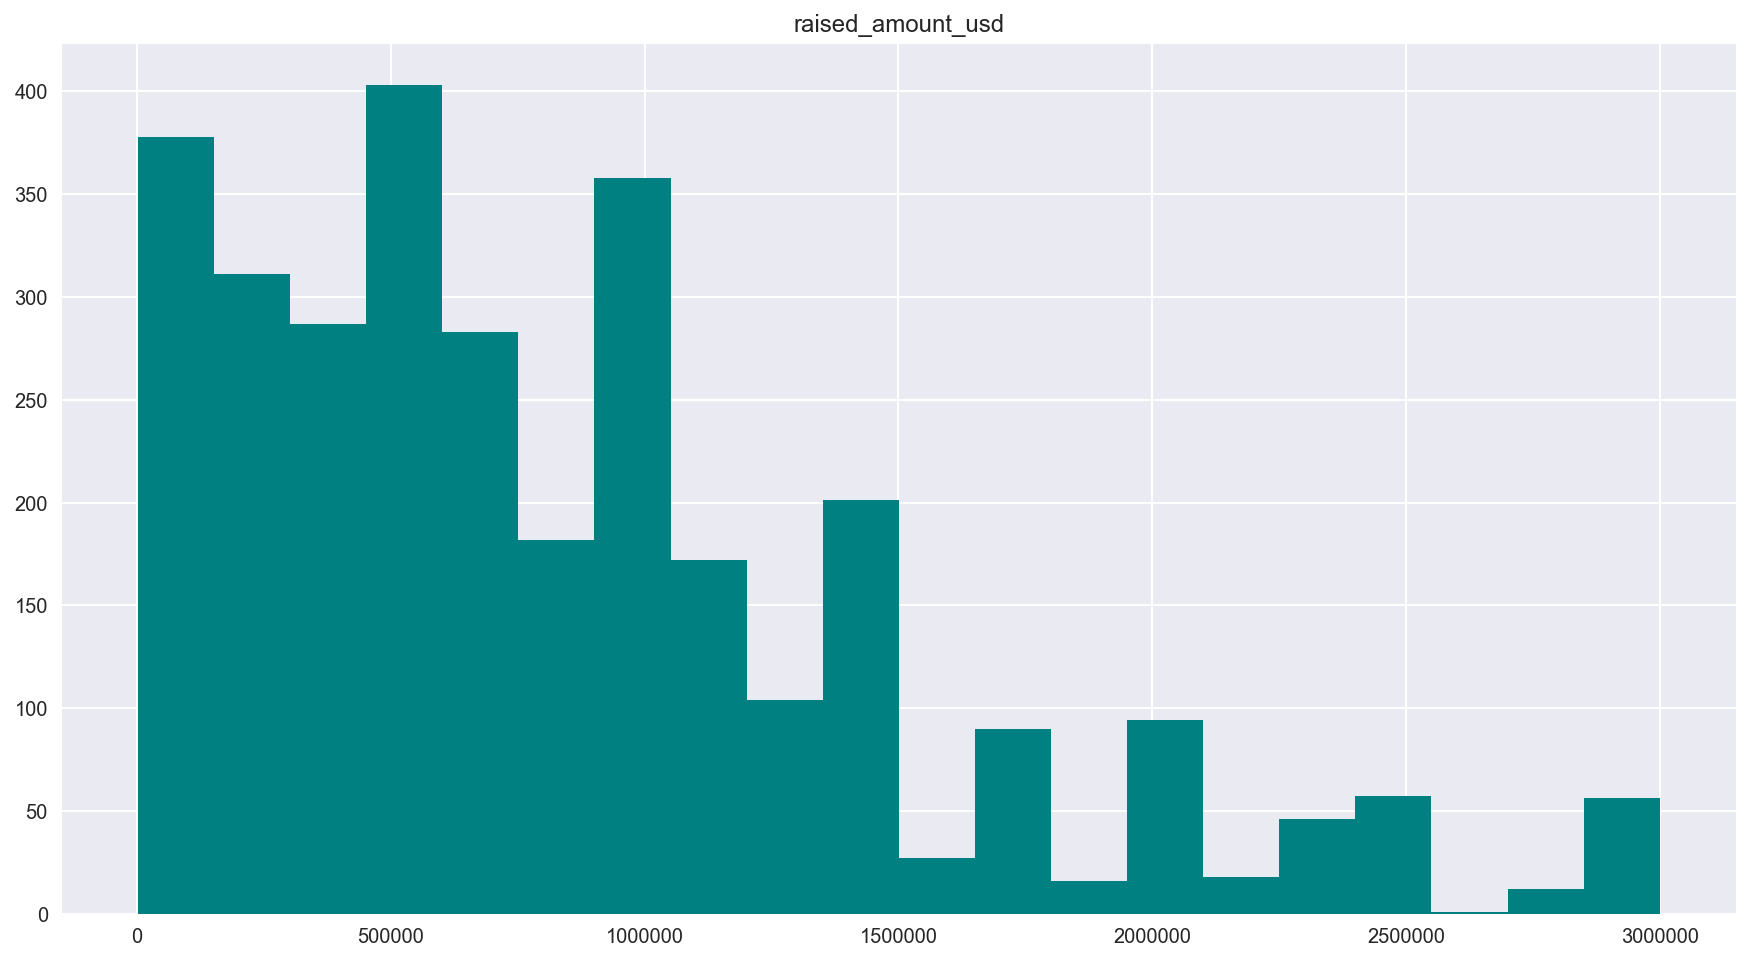

In [105]:
df_funding[(df_funding['funding_round_code'] == 'angel') &
           (df_funding['raised_amount_usd'] <= 3000000)].hist(column='raised_amount_usd', 
                                                               bins=20, 
                                                               color='teal',
                                                              figsize=(15,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f2b7a50>]], dtype=object)

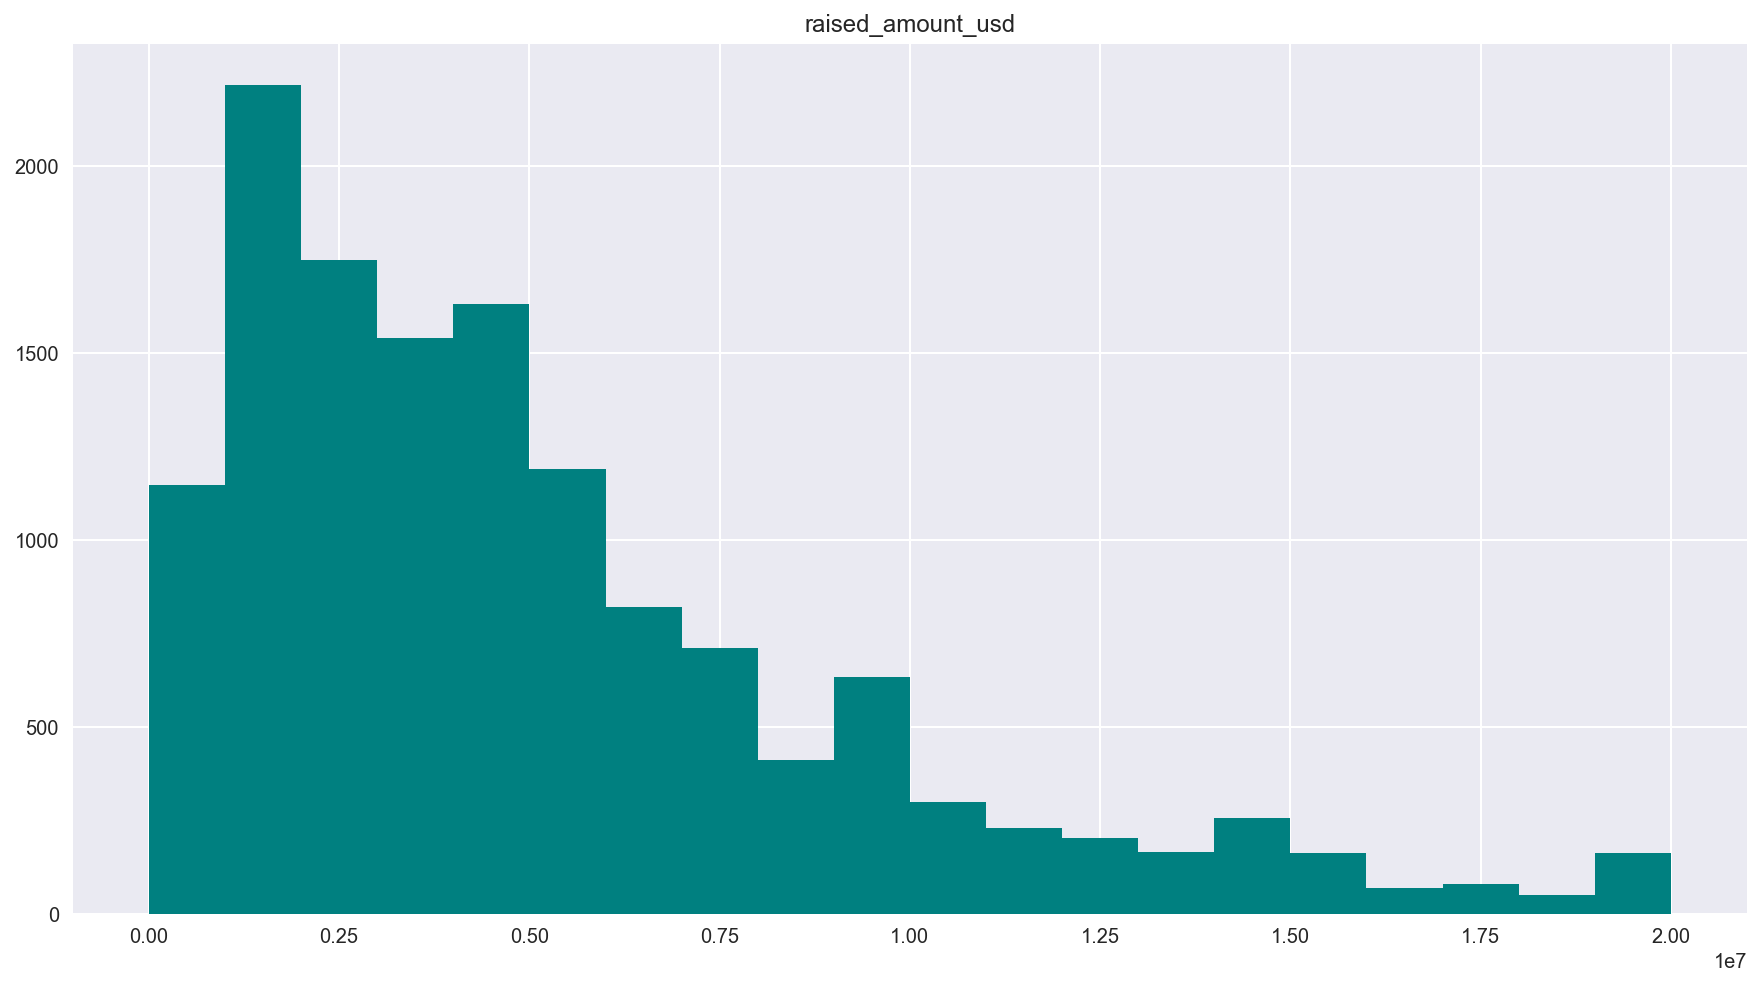

In [87]:
df_funding[(df_funding['funding_round_code'] == 'a') &
           (df_funding['raised_amount_usd'] <= 20000000)].hist(column='raised_amount_usd', 
                                                               bins=20, 
                                                               color='teal',
                                                              figsize=(15,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11303ced0>]], dtype=object)

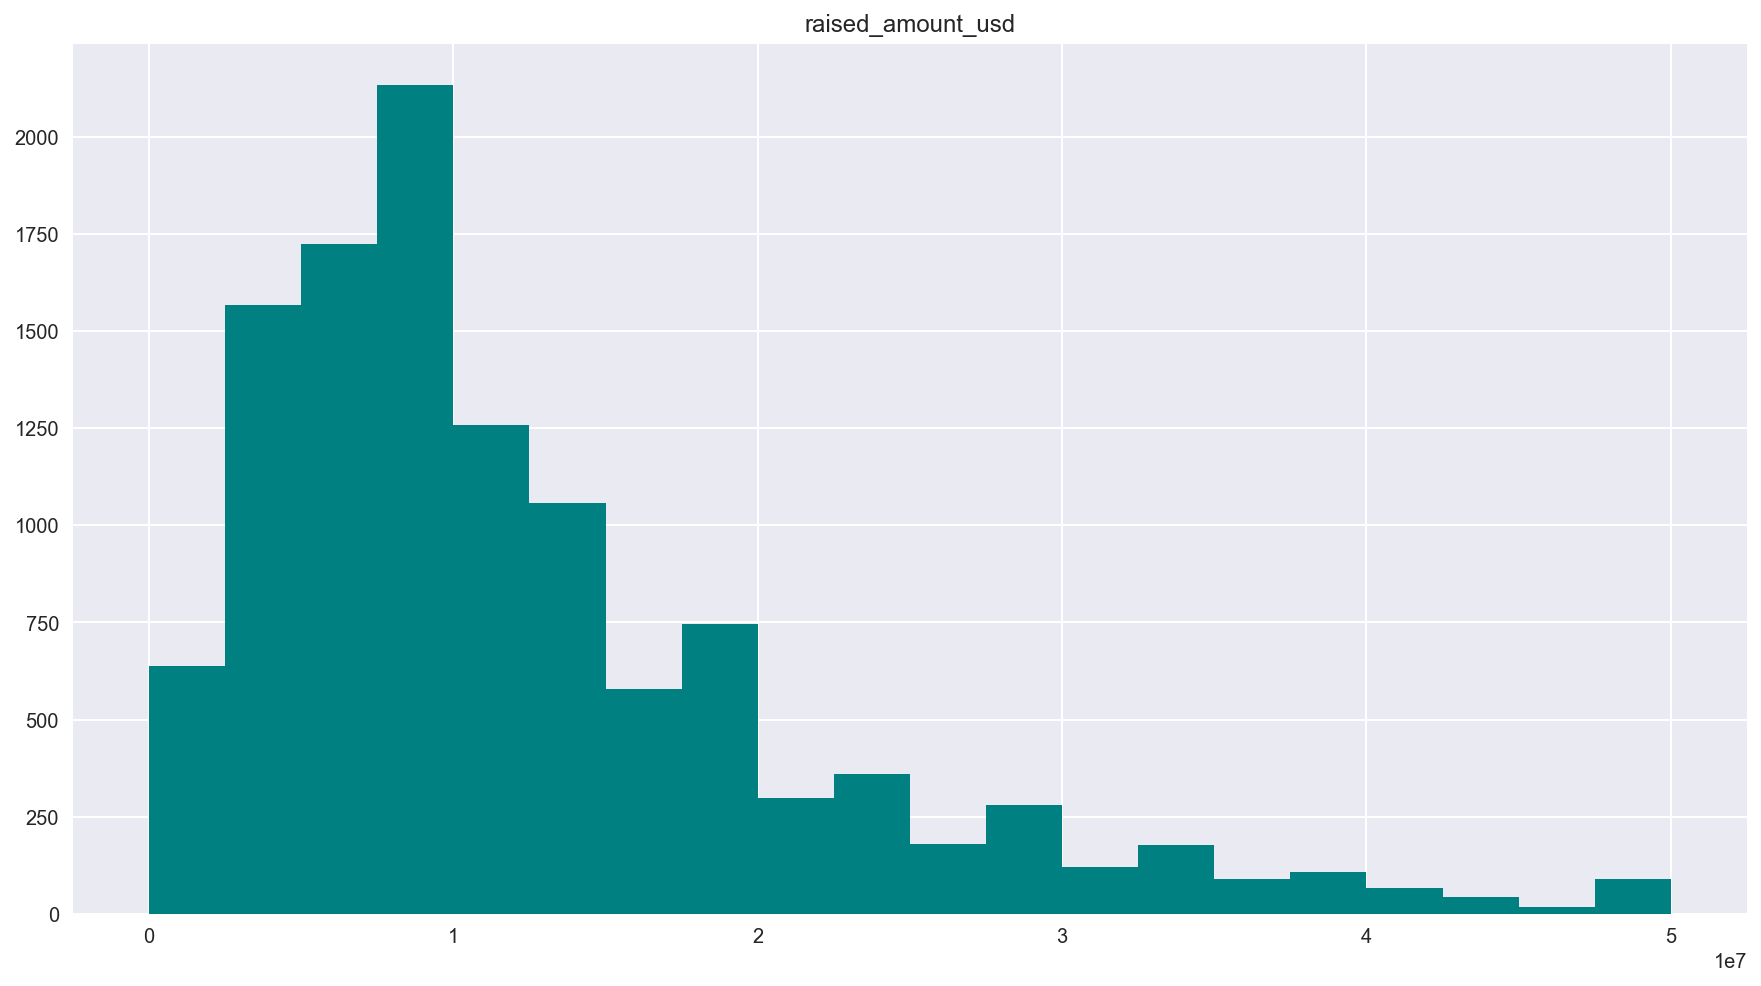

In [77]:
df_funding[(df_funding['funding_round_code'] == 'b') &
           (df_funding['raised_amount_usd'] <= 50000000)].hist(column='raised_amount_usd', 
                                                               bins=20, 
                                                               color='teal',
                                                              figsize=(15,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1133a59d0>]], dtype=object)

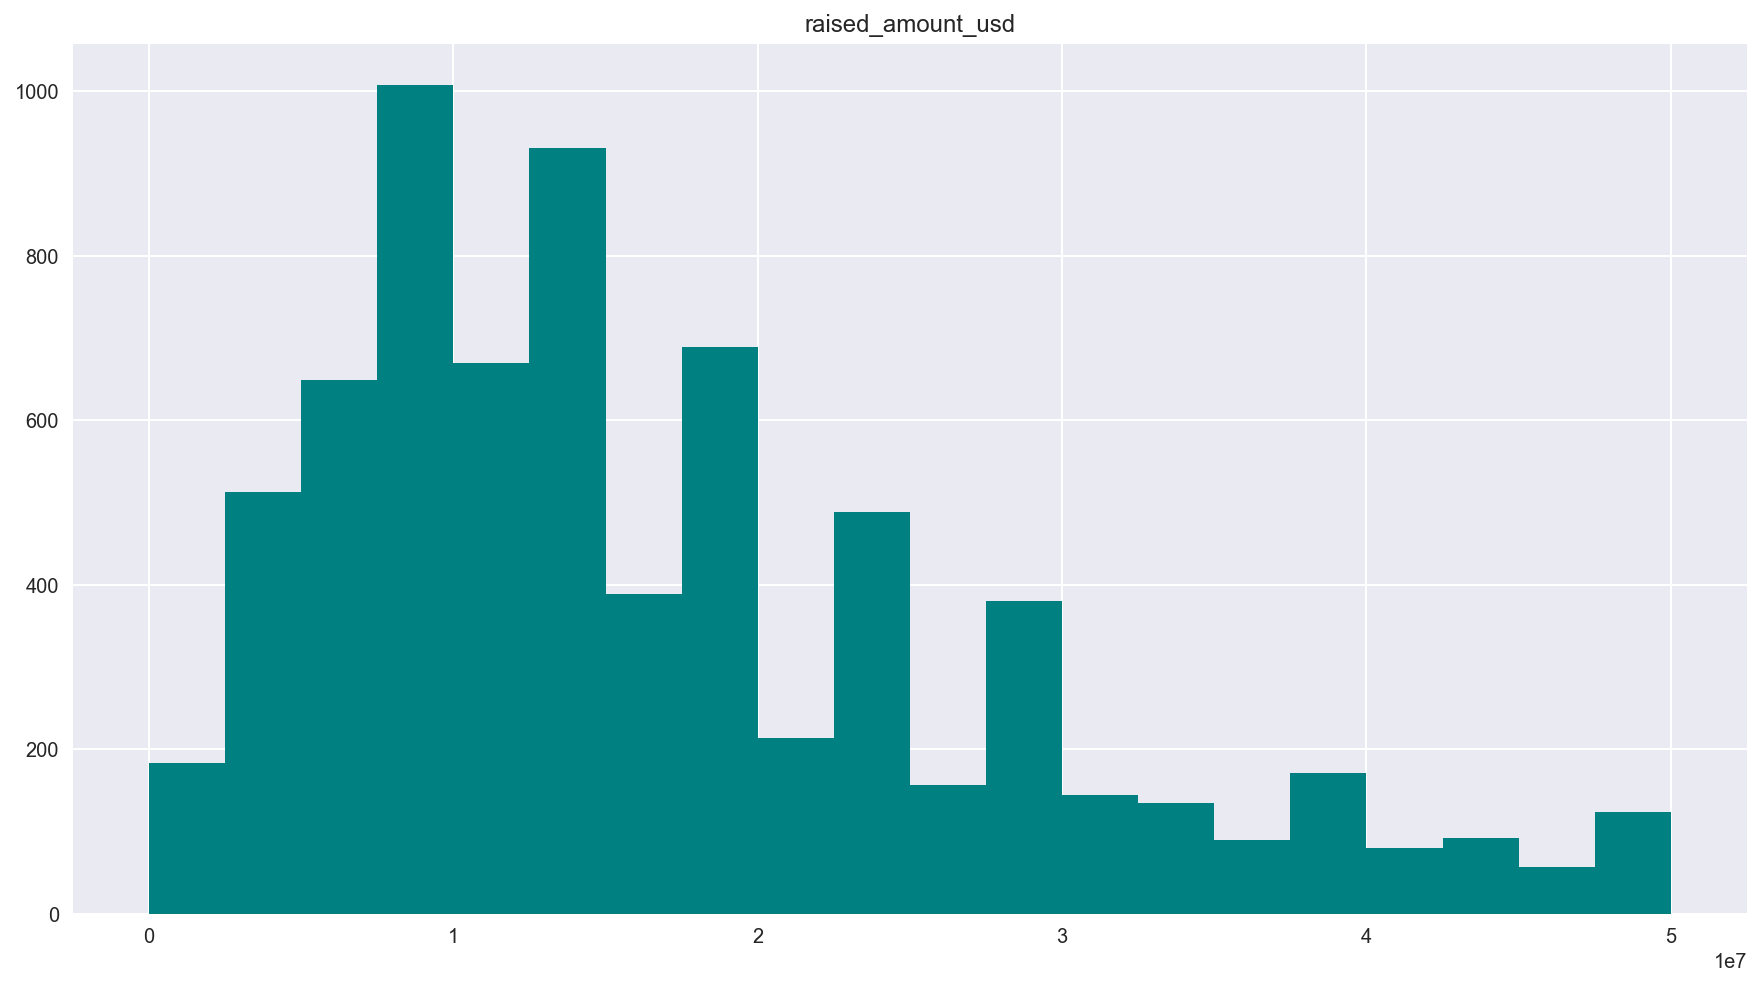

In [75]:
df_funding[(df_funding['funding_round_code'] == 'c') &
           (df_funding['raised_amount_usd'] <= 50000000)].hist(column='raised_amount_usd', 
                                                               bins=20, 
                                                               color='teal',
                                                              figsize=(15,8))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125683ad0>]], dtype=object)

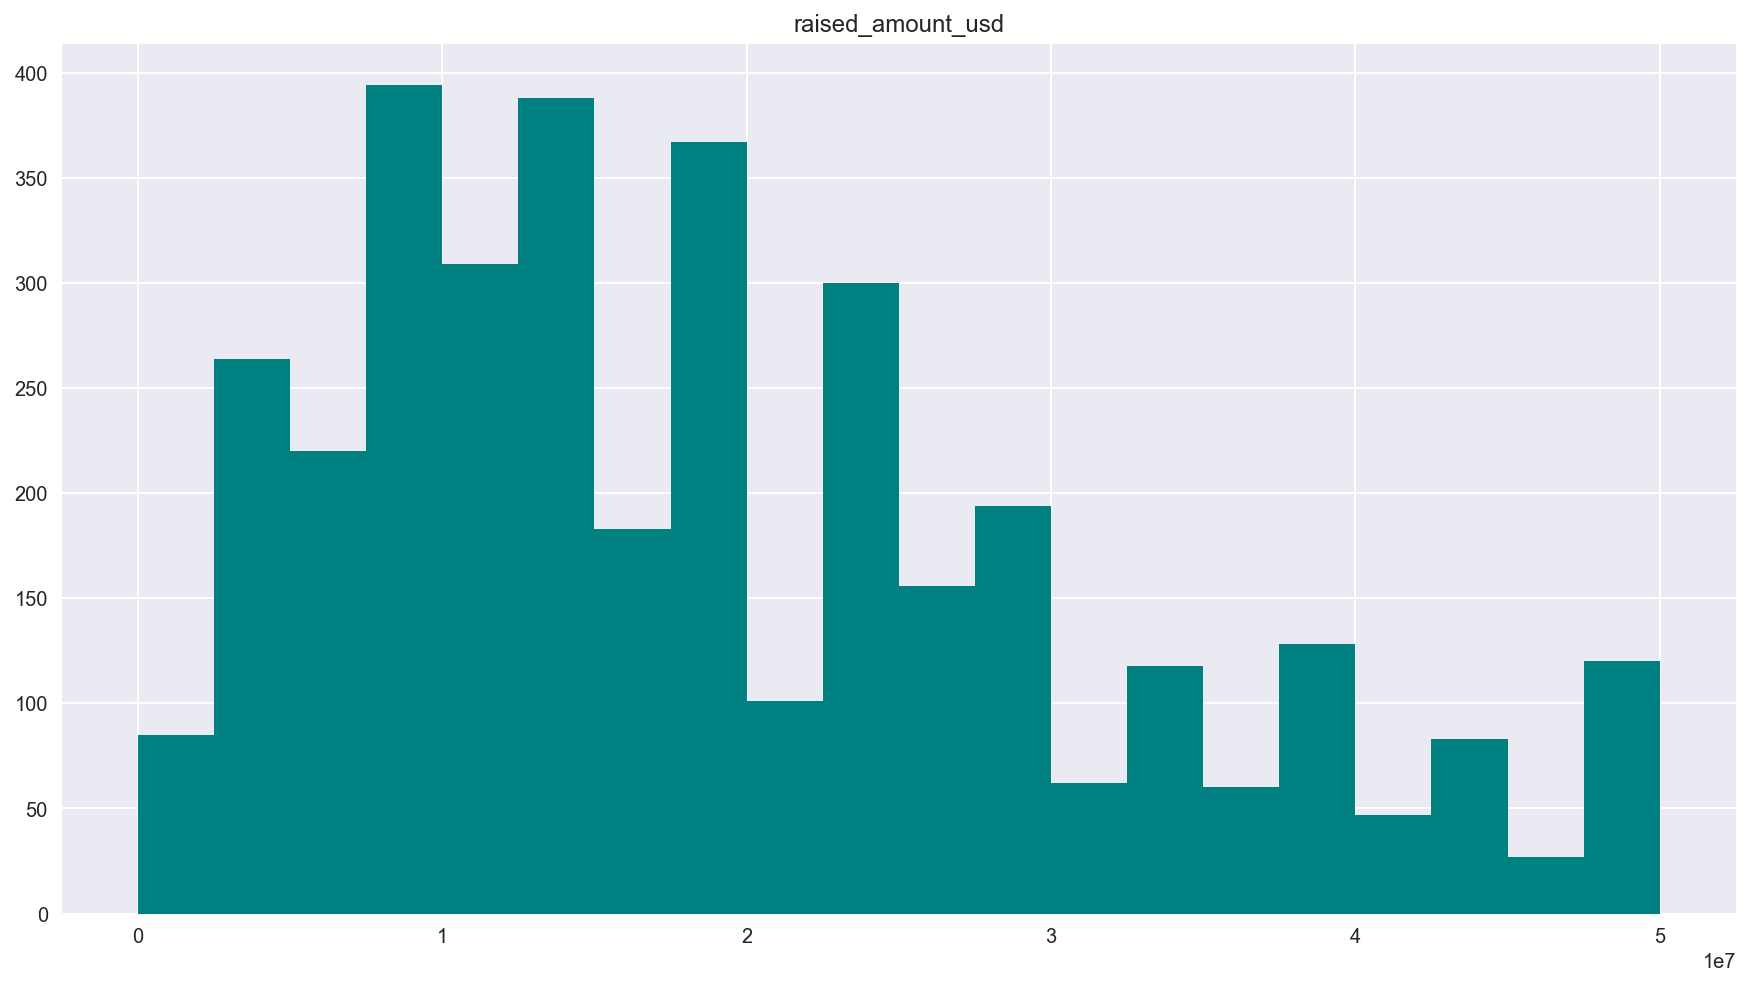

In [100]:
df_funding[(df_funding['funding_round_code'] == 'd') &
           (df_funding['raised_amount_usd'] <= 50000000)].hist(column='raised_amount_usd', 
                                                               bins=20, 
                                                               color='teal',
                                                              figsize=(15,8))

In [164]:
finance_group = df_funding.groupby(['funding_round_code_clean',
                                   'funded_year']).agg({'raised_amount_usd': 'mean'})
finance_group.dropna(inplace=True)
finance_group.info()

finance_group.unstack()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 147 entries, (a, 1987.0) to (series_unknown, 2013.0)
Data columns (total 1 columns):
raised_amount_usd    147 non-null float64
dtypes: float64(1)
memory usage: 1.8+ KB


## Funding Stages One Hot Encoded

In [39]:
df_funding['funding_round_code_clean'] = ['angel' if i == 'angel' else
                                          'seed' if i == 'seed' else
                                          'a' if i == 'a' else
                                          'b' if i == 'b' else
                                          'c' if i == 'c' else
                                          'series_d_above' if i == 'd' else 'series_d_above' if i == 'e' else 
                                          'series_d_above' if i == 'f' else 'series_d_above' if i == 'g' else
                                          'series_unknown' if i == 'unattributed' else
                                          'other' if i == 'partial' else 'other' if i == 'convertible' else 
                                          'other' if i == 'grant' else 'other' if i == 'crowd' else 
                                          'other' if i == 'debt_round' else
                                          'secondary_market' if i == 'private_equity' else 
                                          'secondary_market' if i == 'post_ipo_debt' else 
                                          'secondary_market' if i == 'post_ipo_equity' else 
                                          'secondary_market' if i == 'secondary_market' else
                                          i for i in df_funding['funding_round_code']]

In [139]:
df['angel_funding'] = 0
df['angel_funding'] = [df.raised_amount_usd.iloc[index] + df.angel_funding.iloc[index] if value == 'angel' else
                               0 for index, value in enumerate(df['funding_round_code_clean'])]
# df_funding['seed_funding'] = [df_funding.raised_amount_usd.iloc[index] if value == 'seed' else
#                                   0 for index, value in enumerate(df_funding['funding_round_code_clean'])]
# df_funding['series_a_funding'] = [df_funding.raised_amount_usd.iloc[index] if value == 'a' else
#                                   0 for index, value in enumerate(df_funding['funding_round_code_clean'])]
# df_funding['series_b_funding'] = [df_funding.raised_amount_usd.iloc[index] if value == 'b' else
#                                   0 for index, value in enumerate(df_funding['funding_round_code_clean'])]
# df_funding['series_c_funding'] = [df_funding.raised_amount_usd.iloc[index] if value == 'c' else
#                                   0 for index, value in enumerate(df_funding['funding_round_code_clean'])]
# df_funding['series_d_above_funding'] = [df_funding.raised_amount_usd.iloc[index] if value == 'series_d_above' else
#                                   0 for index, value in enumerate(df_funding['funding_round_code_clean'])]
# df_funding['secondary_market_funding'] = [df_funding.raised_amount_usd.iloc[index] if value == 'secondary_market' else
#                                   0 for index, value in enumerate(df_funding['funding_round_code_clean'])]
# df_funding['other_funding'] = [df_funding.raised_amount_usd.iloc[index] if value == 'other' else
#                                   0 for index, value in enumerate(df_funding['funding_round_code_clean'])]

In [249]:
df_funding[(df_funding['series_a_funding'] > 0) & (df_funding['series_c_funding'] == 0)]

,funding_round_id,investor_object_id,funded_object_id,raised_amount_usd,funded_at,funding_round_code,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,...,funded_year,funding_round_code_clean,angel_funding,seed_funding,series_a_funding,series_b_funding,series_c_funding,series_d_above_funding,secondary_market_funding,other_funding
4,3,p:2603,c:5,12700000.0,2005-05-01,a,115000000.0,NaN,3,0,...,2005.0,a,0.0,0.0,12700000.0,0.0,0.0,0.0,0.0,0.0
5,3,p:570,c:5,12700000.0,2005-05-01,a,115000000.0,NaN,3,0,...,2005.0,a,0.0,0.0,12700000.0,0.0,0.0,0.0,0.0,0.0
6,3,f:4,c:5,12700000.0,2005-05-01,a,115000000.0,NaN,3,0,...,2005.0,a,0.0,0.0,12700000.0,0.0,0.0,0.0,0.0,0.0
13,6,f:6,c:9,1500000.0,2007-01-01,a,8500000.0,10000000.0,1,0,...,2007.0,a,0.0,0.0,1500000.0,0.0,0.0,0.0,0.0,0.0
19,9,f:48,c:14,6300000.0,2007-05-01,a,NaN,NaN,2,0,...,2007.0,a,0.0,0.0,6300000.0,0.0,0.0,0.0,0.0,0.0
20,9,f:83,c:14,6300000.0,2007-05-01,a,NaN,NaN,2,0,...,2007.0,a,0.0,0.0,6300000.0,0.0,0.0,0.0,0.0,0.0
27,13,f:12,c:16,13500000.0,2007-06-01,a,NaN,NaN,3,0,...,2007.0,a,0.0,0.0,13500000.0,0.0,0.0,0.0,0.0,0.0
28,13,f:10,c:16,13500000.0,2007-06-01,a,NaN,NaN,3,0,...,2007.0,a,0.0,0.0,13500000.0,0.0,0.0,0.0,0.0,0.0
29,13,f:11,c:16,13500000.0,2007-06-01,a,NaN,NaN,3,0,...,2007.0,a,0.0,0.0,13500000.0,0.0,0.0,0.0,0.0,0.0
30,14,f:14,c:15,3710000.0,2007-06-01,a,NaN,17500000.0,6,0,...,2007.0,a,0.0,0.0,3710000.0,0.0,0.0,0.0,0.0,0.0


In [162]:
df_funding['angel'] = [1 if i == 'angel' else 0 for i in df_funding['funding_round_code_clean']]
df_funding['seed'] = [1 if i == 'seed' else 0 for i in df_funding['funding_round_code_clean']]
df_funding['series_a'] = [1 if i == 'a' else 0 for i in df_funding['funding_round_code_clean']]
df_funding['series_b'] = [1 if i == 'b' else 0 for i in df_funding['funding_round_code_clean']]
df_funding['series_c'] = [1 if i == 'c' else 0 for i in df_funding['funding_round_code_clean']]
df_funding['series_d_above'] = [1 if i == 'series_d_above' else 
                           0 for i in df_funding['funding_round_code_clean']]
df_funding['secondary_market'] = [1 if i == 'secondary_market' else 
                                  0 for i in df_funding['funding_round_code_clean']]
df_funding['series_unknown'] = [1 if 'series_unknown' else 
                                0 for i in df_funding['funding_round_code_clean']]
df_funding['other'] = [1 if i == 'other' else 0 for i in df_funding['funding_round_code_clean']]

In [201]:
df_funding.apply()

'f:1'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a4fc9d0>]], dtype=object)

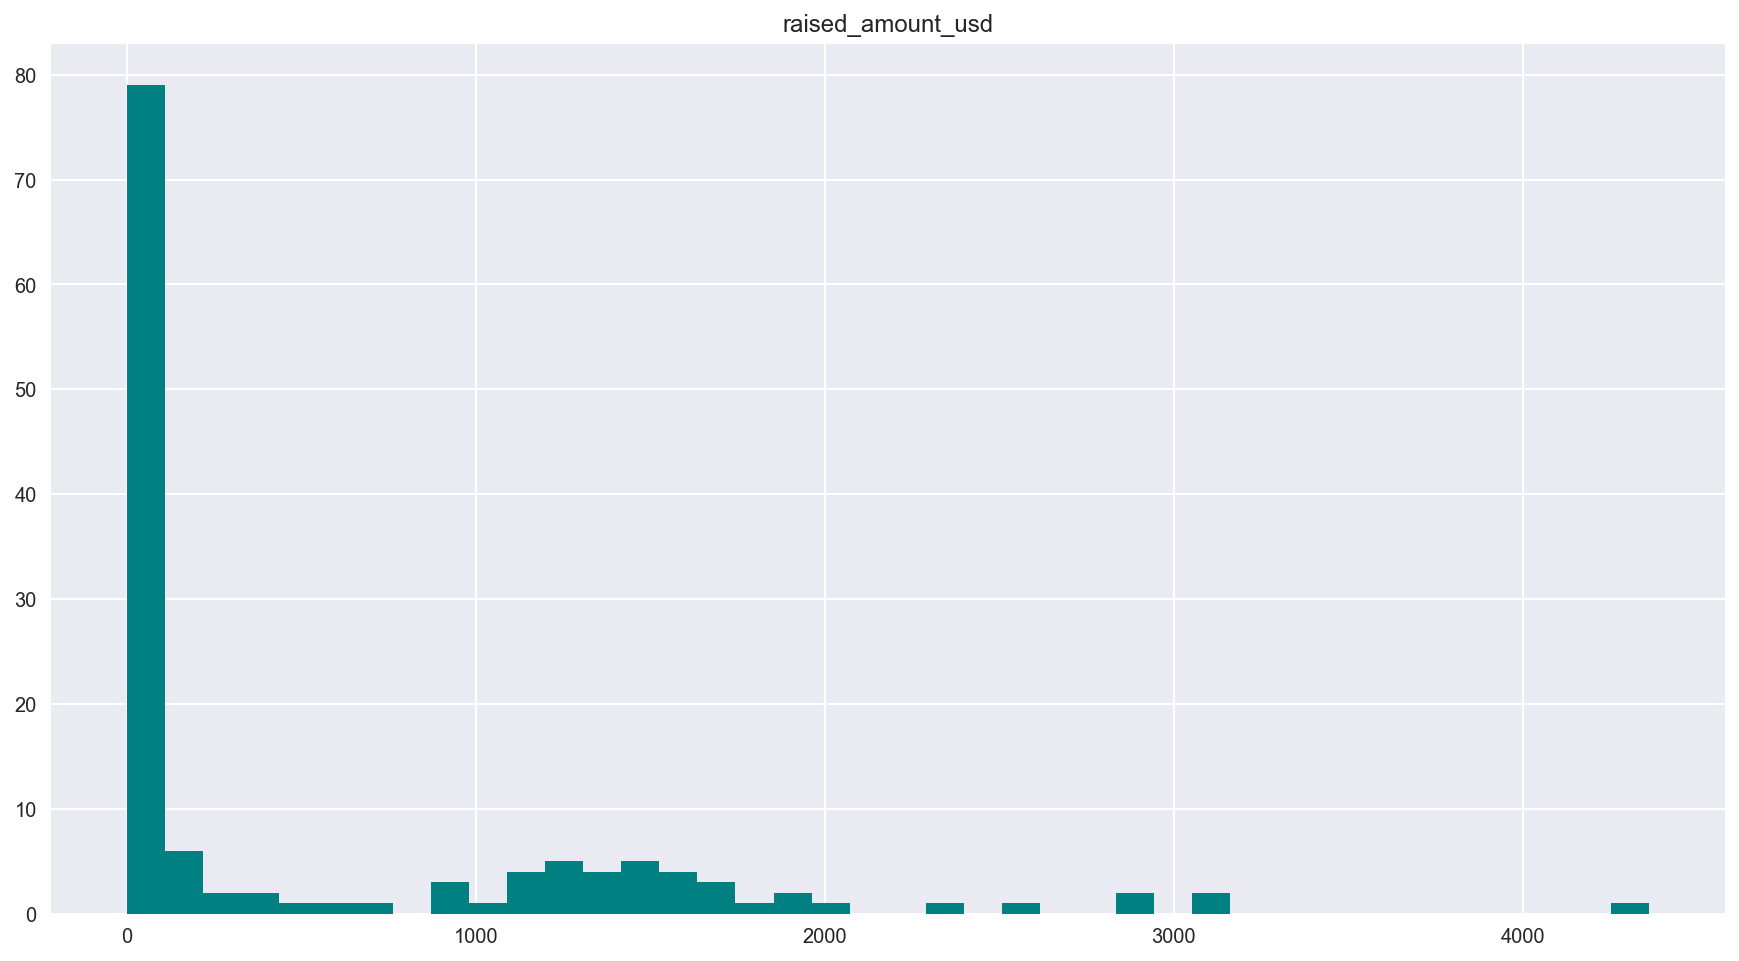

In [136]:
finance_group.hist(bins=40, figsize=(15,8), color='teal')

In [11]:
subset_fin = finance_group[finance_group['raised_amount_usd'] <= 10000000]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x104bd3d90>]], dtype=object)

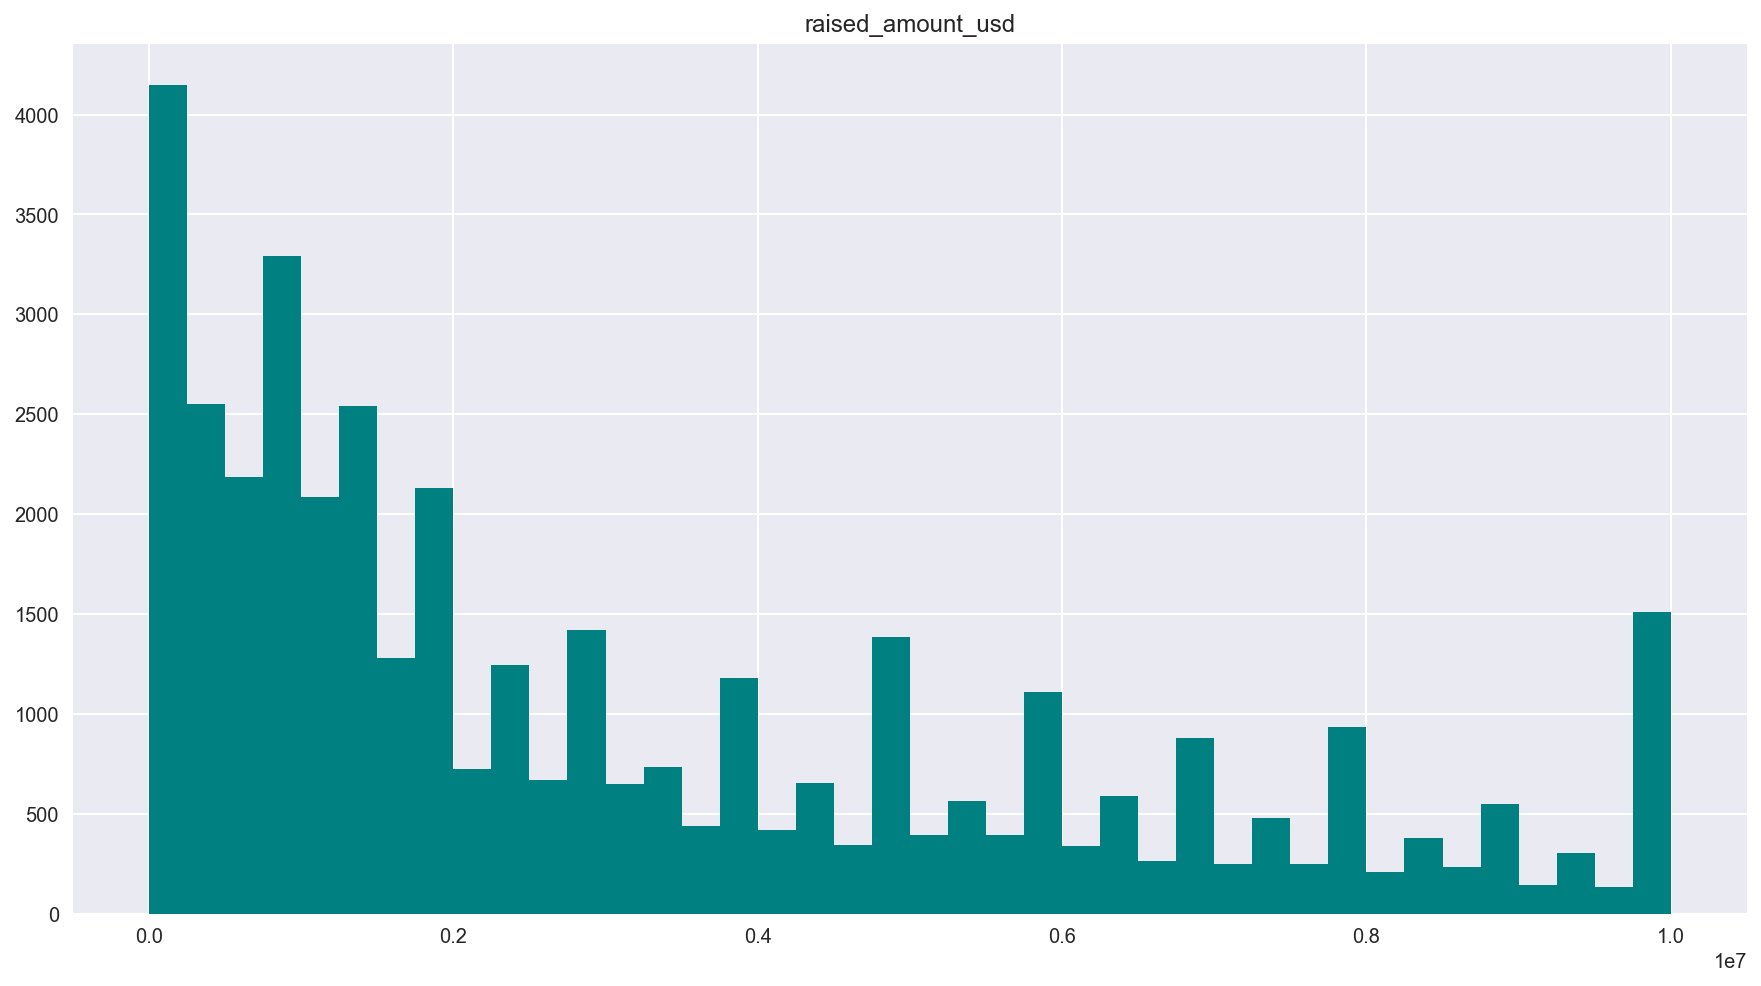

In [12]:
subset_fin.hist(bins=40, figsize=(15,8), color='teal')

In [13]:
company_group = df_funding.groupby(['funded_object_id', 
                                    'funding_round_type']).agg({'raised_amount_usd': 'mean', 
                                                                'funded_at': 'max', 
                                                                'investor_object_id': 'count'})
company_group.dropna(inplace=True)
company_group.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24734 entries, (c:1, series-a) to (c:9994, angel)
Data columns (total 3 columns):
investor_object_id    24734 non-null int64
raised_amount_usd     24734 non-null float64
funded_at             24734 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 821.1+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110edf1d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110df8310>]], dtype=object)

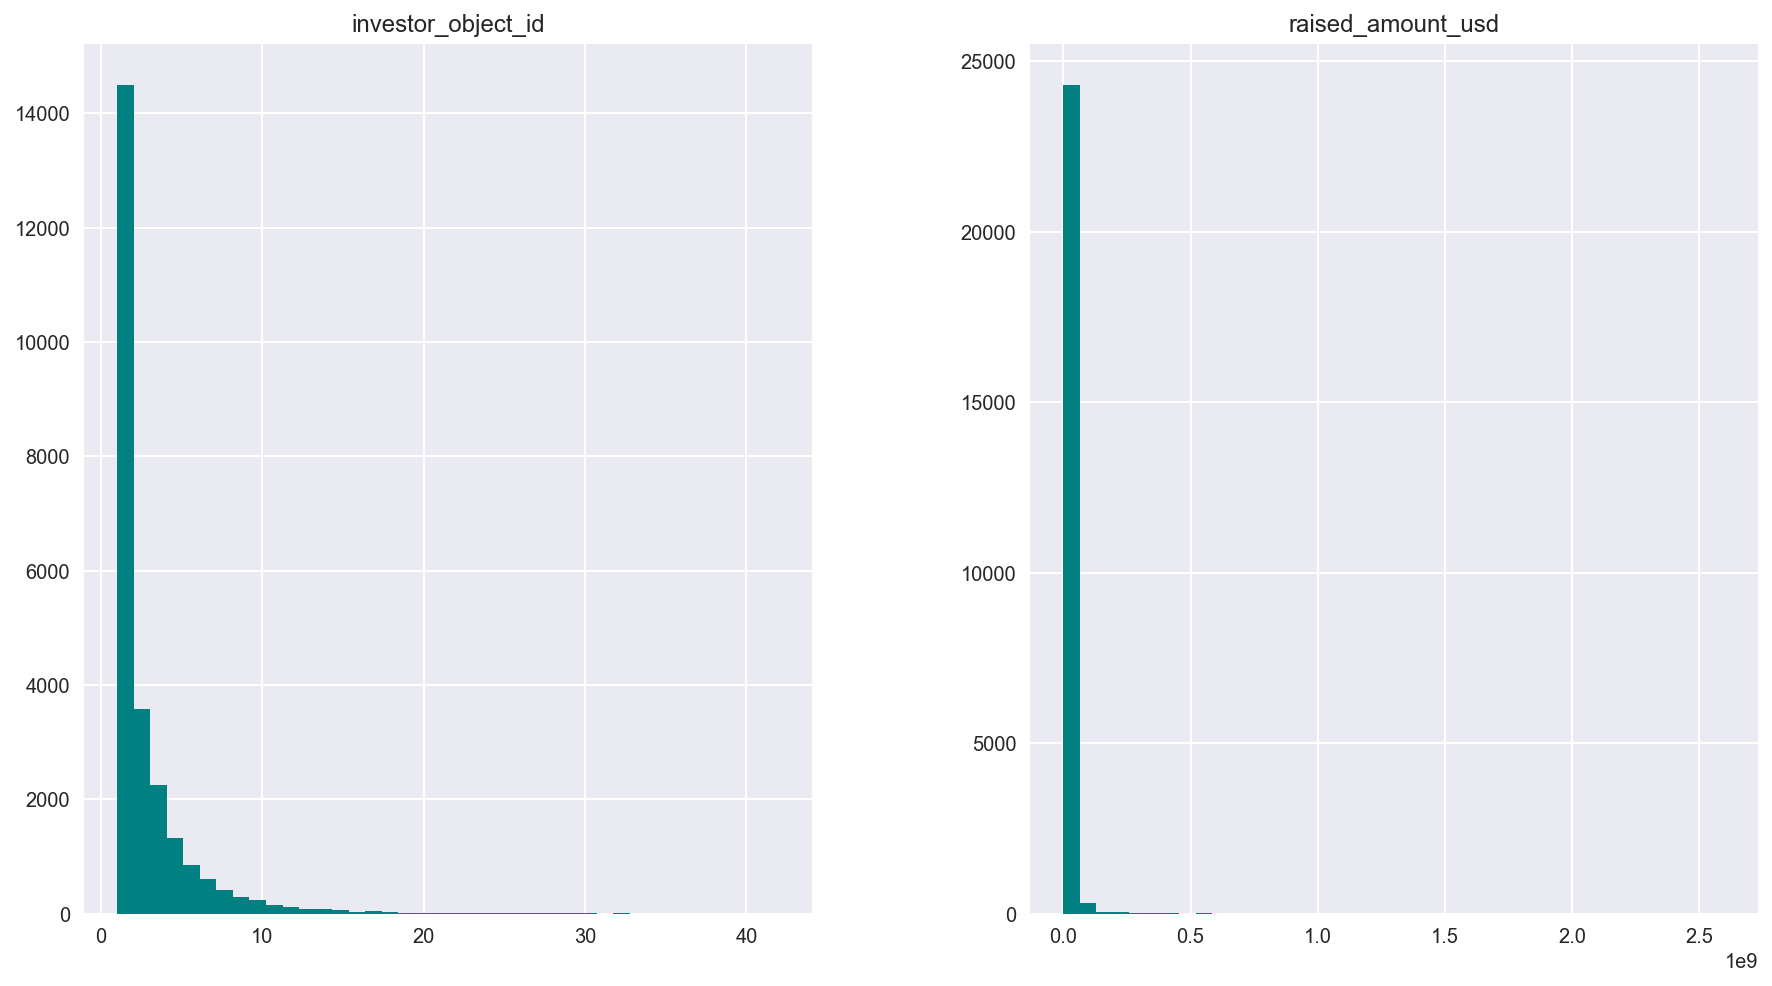

In [14]:
company_group.hist(bins=40, figsize=(15,8), color='teal')

In [15]:
subset_comp = company_group[(company_group['raised_amount_usd'] > 100000) & 
                            (company_group['raised_amount_usd'] <= 10000000)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1108f4810>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1107b9250>]], dtype=object)

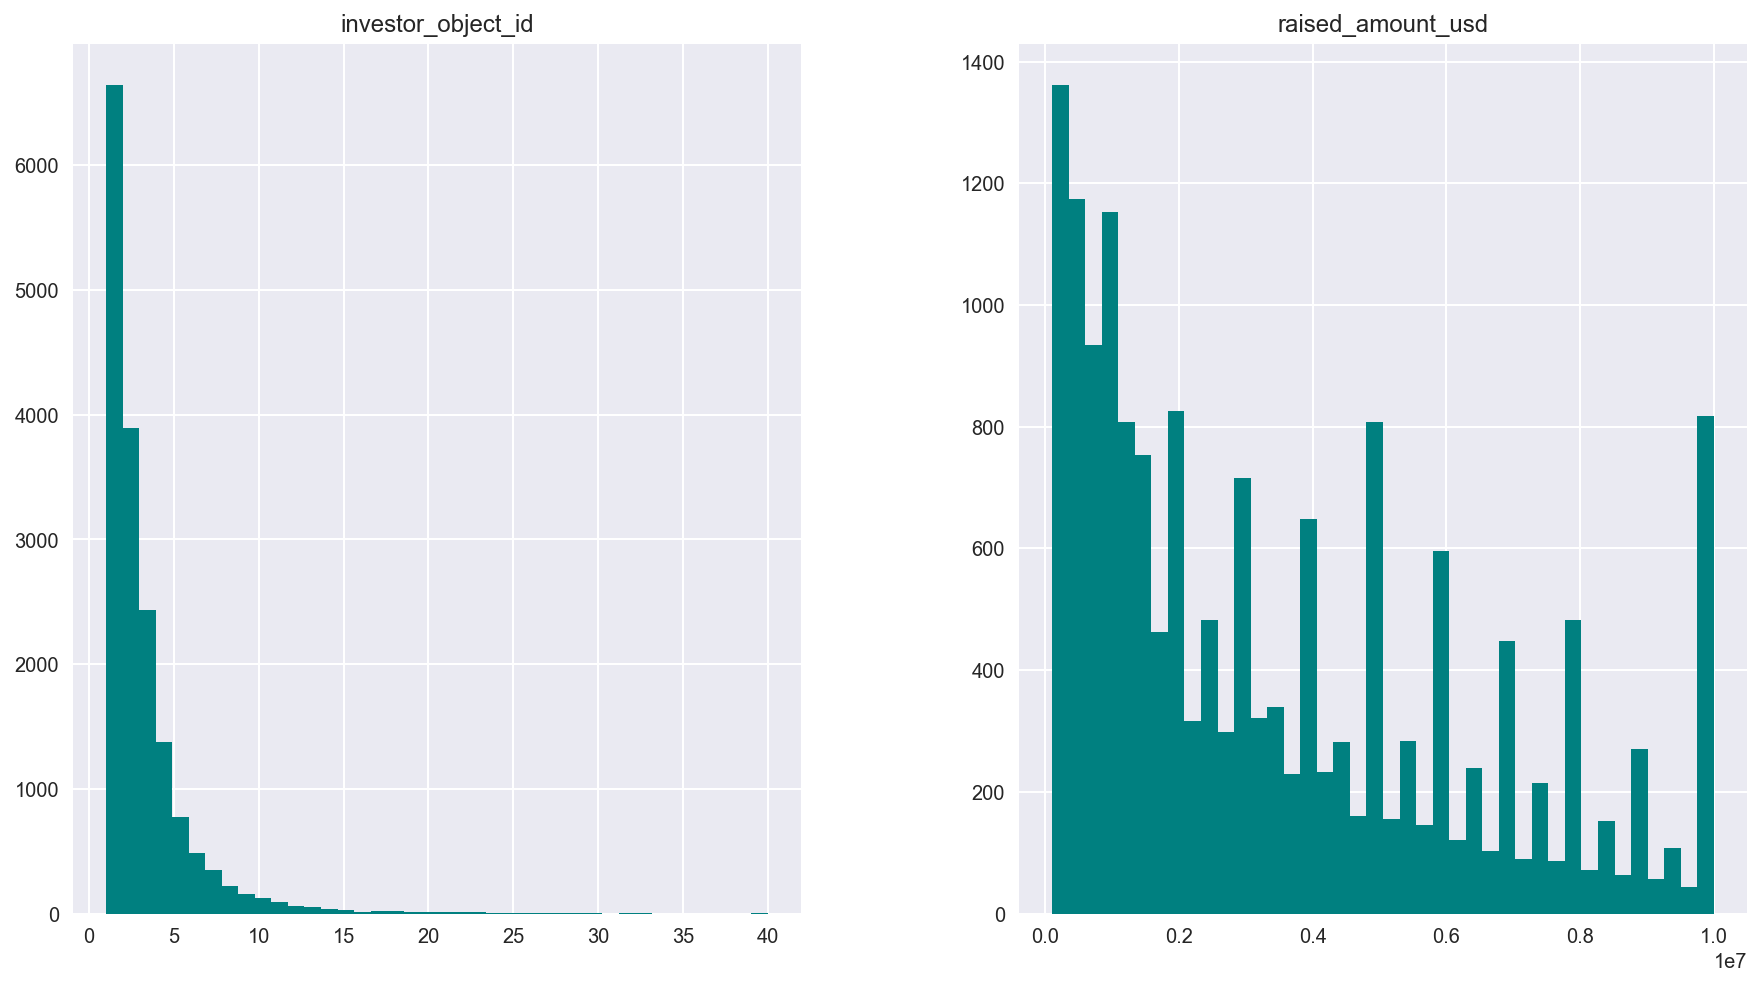

In [16]:
subset_comp.hist(bins=40, figsize=(15,8), color='teal')

In [ ]:
agg_columns    = ["raised_amount_usd", "pre_money_valuation_usd", "post_money_valuation_usd"]
append_columns = ["funding_round_type", "investor_object_id", "funding_round_type", "funding_round_code"]
    
for col in agg_columns:
    subset[col] = subset[col].mean()
    
for col in append_columns:
    subset[col] = subset[col].mode()

In [185]:
mitch = df_funding.head(50)

def transform_data(subset):
    
    agg_columns    = ["raised_amount_usd", "pre_money_valuation_usd", "post_money_valuation_usd"]
    append_columns = ["funding_round_type", "investor_object_id", "funding_round_type", "funding_round_code"]
    
    for col in agg_columns:
        subset[col] = subset[col].mean()
    
    for col in append_columns:
        subset[col] = subset[col].mode()
    
    # Remove columns not in agg or append
    final_columns = list(set(subset.columns) - set(agg_columns + append_columns))
    
    # Set index
    subset.index = subset[["funded_object_id", "investor_object_id", "funding_round_type", "funding_round_id"]]
    
    return subset[final_columns]

mitch.groupby(["funded_object_id", "funding_round_type", "funding_round_id"]).apply(transform_data)

is_first_round  \
funded_object_id funding_round_type funding_round_id                                         
c:13             series-a           8                (c:13, nan, nan, 8)                 0   
                                                     (c:13, nan, nan, 8)                 0   
                                                     (c:13, nan, nan, 8)                 0   
                                                     (c:13, nan, nan, 8)                 0   
c:14             series-a           9                (c:14, nan, nan, 9)                 0   
                                                     (c:14, nan, nan, 9)                 0   
c:15             angel              10               (c:15, nan, nan, 10)                0   
                                    11               (c:15, nan, nan, 11)                0   
                 series-a           14               (c:15, nan, nan, 14)                0   
                                                     (c:15, nan, nan, 14)                0   
                                                     (c:15, nan, nan, 14)                0   
                                                     (c:15, nan, nan, 14)                0   
                                                     (c:15, nan, nan, 14)                0   
                                                     (c:15, nan, nan, 14)                0   
c:16             series-a           13               (c:16, nan, nan, 13)                0   
                                                     (c:16, nan, nan, 13)                0   
                                                     (c:16, nan, nan, 13)                0   
                 series-b           12               (c:16, nan, nan, 12)                0   
                                                     (c:16, nan, nan, 12)                0   
                                                     (c:16, nan, nan, 12)                0   
                                                     (c:16, nan, nan, 12)                0   
c:18             series-b           16               (c:18, nan, nan, 16)                0   
                                                     (c:18, nan, nan, 16)                0   
c:22             series-a           18               (c:22, nan, nan, 18)                0   
c:23             series-a           19               (c:23, nan, nan, 19)                1   
                                                     (c:23, nan, nan, 19)                1   
                                                     (c:23, nan, nan, 19)                1   
c:26             series-a           17               (c:26, nan, nan, 17)                1   
c:27             series-a           20               (c:27, nan, nan, 20)                0   
                                                     (c:27, nan, nan, 20)                0   
                 series-b           21               (c:27, nan, nan, 21)                0   
                                                     (c:27, nan, nan, 21)                0   
                                                     (c:27, nan, nan, 21)                0   
c:30             series-a           22               (c:30, nan, nan, 22)                1   
                                                     (c:30, nan, nan, 22)                1   
c:4              series-b           1                (c:4, nan, nan, 1)                  0   
                                                     (c:4, nan, nan, 1)                  0   
c:5              angel              2                (c:5, nan, nan, 2)                  0   
                                                     (c:5, nan, nan, 2)                  0   
                 series-a           3                (c:5, nan, nan, 3)                  0   
                                                     (c:5, nan, nan, 3)                  0   
                                  

In [7]:
df_funding.set_index(
        ['funded_object_id', df_funding.groupby('funded_object_id').cumcount()]
    ).investor_object_id.unstack().add_prefix('investor').reset_index()

# df_funding.set_index(
#         ['funded_object_id', df_funding.groupby('funded_object_id').cumcount()]
#     ).investor_object_id.unstack().add_prefix('investor').reset_index()

,funded_object_id,investor0,investor1,investor2,investor3,investor4,investor5,investor6,investor7,investor8,...,investor48,investor49,investor50,investor51,investor52,investor53,investor54,investor55,investor56,investor57
0,c:1,f:430,f:3,f:4,f:430,f:3,f:262,f:4,f:3,f:430,...,None,None,None,None,None,None,None,None,None,None
1,c:1001,p:640,p:2716,f:48,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,c:10014,c:591,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,c:10015,f:74,f:737,f:745,f:74,f:737,f:446,f:745,f:74,f:737,...,None,None,None,None,None,None,None,None,None,None
4,c:100155,f:374,f:1591,f:8011,f:4459,f:1591,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,c:10018,c:283,f:147,f:552,f:91,f:147,f:552,c:283,f:518,f:147,...,None,None,None,None,None,None,None,None,None,None
6,c:100189,f:1798,p:23613,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,c:10021,c:10020,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,c:100238,c:164233,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,c:100243,f:8012,f:10904,f:10905,f:8012,f:10906,f:2372,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [10]:
len(df_funding.funded_object_id.unique())

21607

In [13]:
df_funding['funded_at'] = pd.to_datetime(pd.Series(df_funding['funded_at']))

In [51]:
pd.DataFrame(df_funding.raised_amount_usd.describe())

,raised_amount_usd
count,7.333100e+04
mean,1.280985e+07
std,4.318184e+07
min,1.000000e+03
25%,1.500000e+06
50%,5.421200e+06
75%,1.400000e+07
max,3.200000e+09


In [143]:
df_funding['year'] = df_funding.funded_at.dt.year
df_funding['month'] = df_funding.funded_at.dt.month
df_funding['day'] = df_funding.funded_at.dt.day

In [82]:
df_funding['log_raised_amount_usd'] = np.log1p(df_funding["raised_amount_usd"])

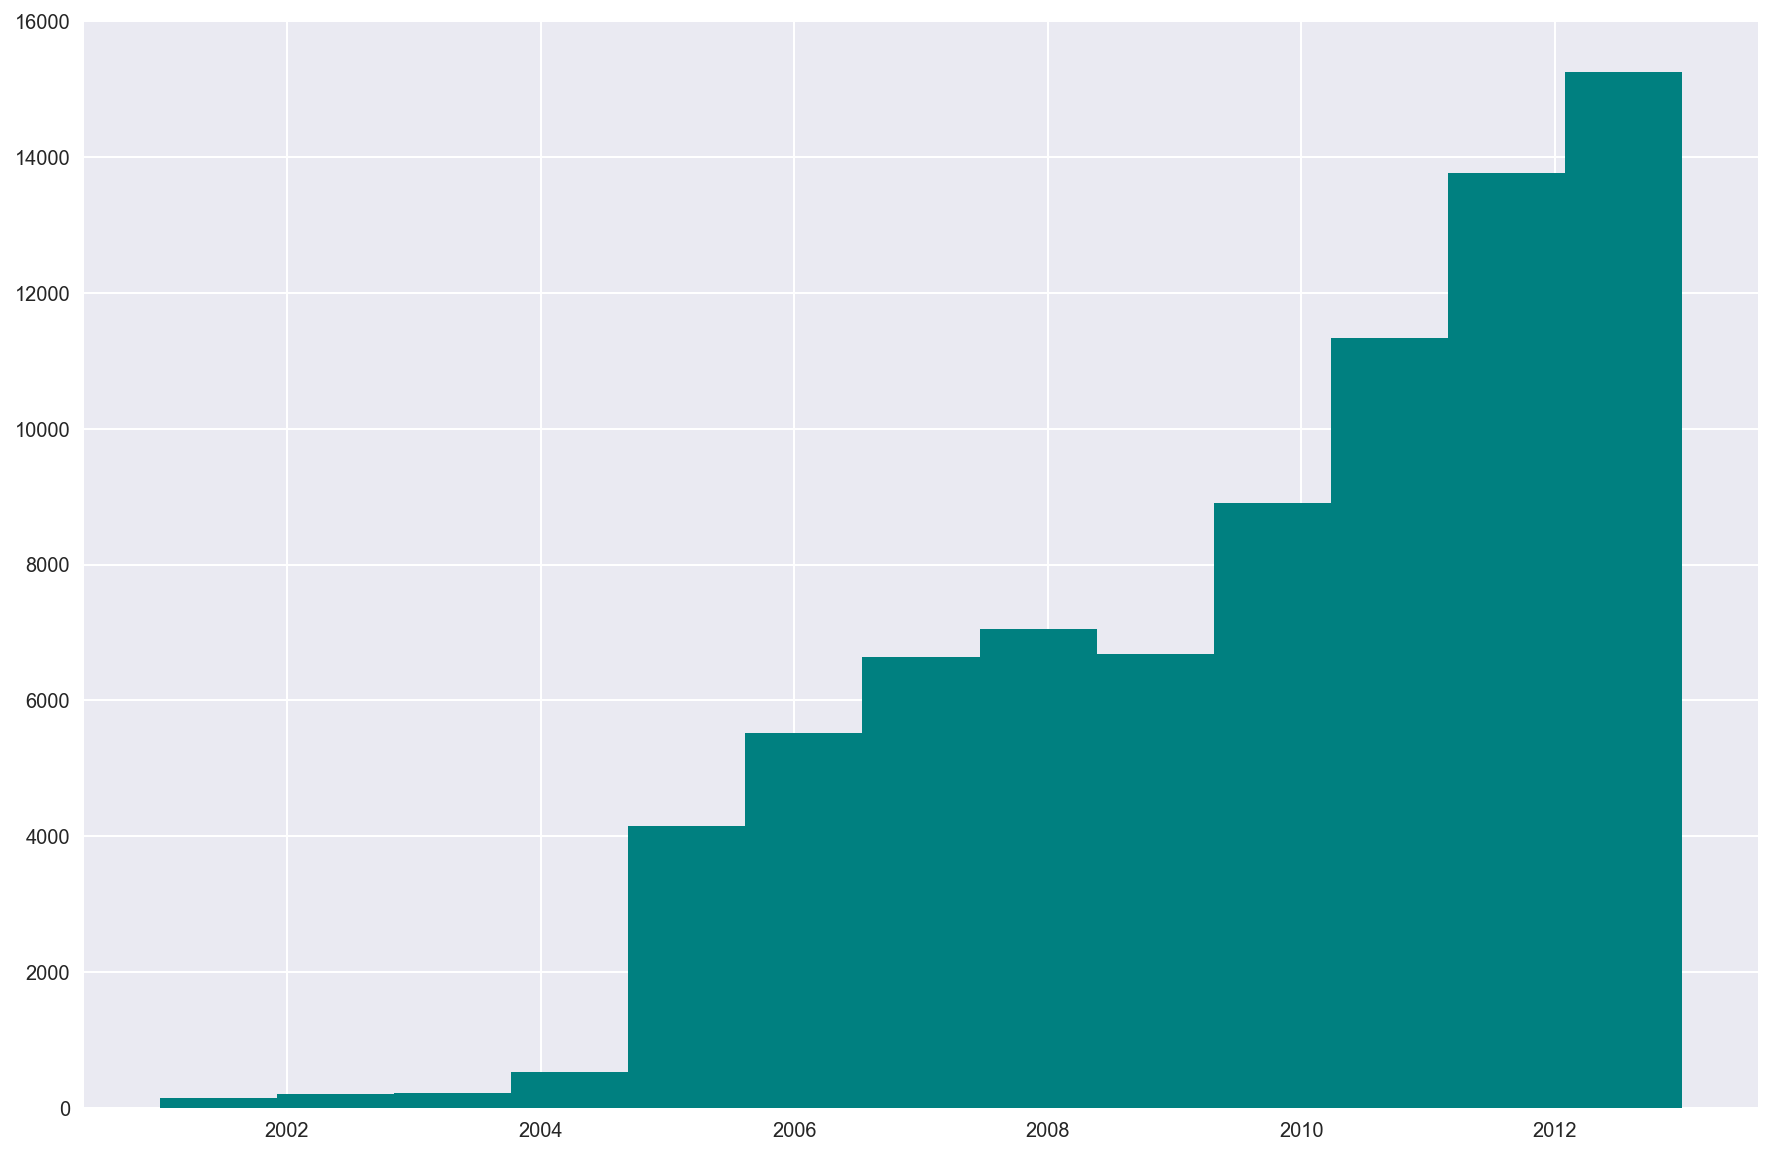

In [144]:
df_funding[df_funding['year'] > 2000].year.hist(bins=13, color='teal', figsize=(15,10))


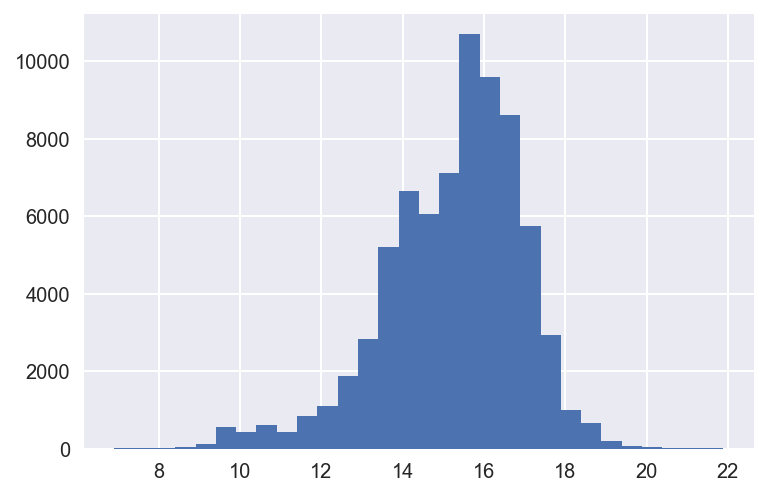

In [86]:
df_funding.log_raised_amount_usd.hist(bins=30)


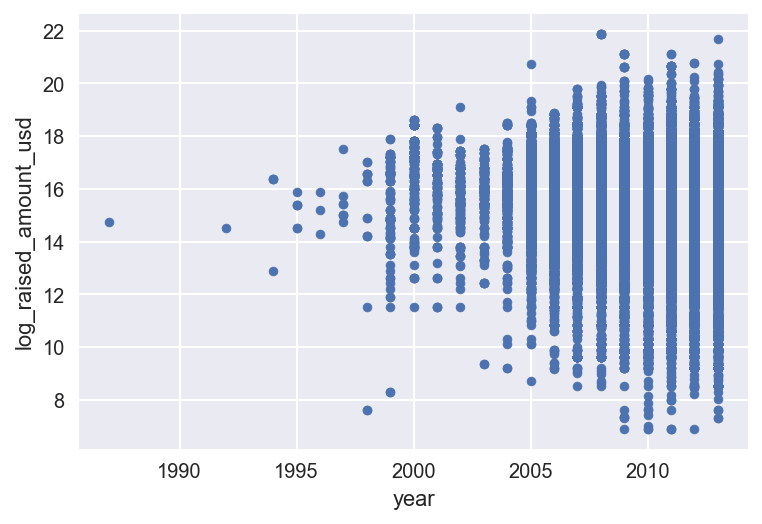

In [83]:
df_funding.plot.scatter(x='year', y='log_raised_amount_usd')

In [ ]:
# part = df_funding[df_funding['participants'] >= 1]
# df_funding['proportional_amount_raised_usd'] = df_funding['raised_amount_usd'] / df_funding[df_funding['participants'] >= 1]



#### Deleting df_objects columns

In [11]:
# del df_objects['logo_height']
# del df_objects['logo_url']
# del df_objects['logo_width']
# del df_objects['created_at']
# del df_objects['created_by']
# del df_objects['updated_at']
# del df_objects['twitter_username']

In [43]:
df_objects[df_objects['entity_type'] == 'Company'].status.value_counts()

operating    183441
acquired       9394
closed         2584
ipo            1134
Name: status, dtype: int64

In [64]:
what_category = df_objects.category_code.unique()
print len(what_category)
print what_category

df_objects.category_code.value_counts()

43
['web' 'games_video' 'network_hosting' 'advertising' 'cleantech' None
 'enterprise' 'other' 'consulting' 'mobile' 'health' 'software' 'analytics'
 'finance' 'education' 'medical' 'manufacturing' 'biotech' 'ecommerce'
 'public_relations' 'hardware' 'search' 'news' 'government' 'security'
 'photo_video' 'travel' 'semiconductor' 'social' 'legal' 'transportation'
 'hospitality' 'sports' 'nonprofit' 'fashion' 'messaging' 'music'
 'automotive' 'design' 'real_estate' 'local' 'nanotech' 'pets']


software            17922
web                 15118
other               13617
ecommerce            9065
games_video          7520
mobile               6862
advertising          6098
consulting           5006
enterprise           4441
biotech              4430
hardware             2951
education            2901
public_relations     2846
network_hosting      2350
search               2182
cleantech            1940
health               1698
finance              1386
social               1310
security             1171
medical              1153
analytics            1022
legal                1012
travel                936
local                 785
news                  768
hospitality           768
semiconductor         696
manufacturing         680
sports                675
music                 581
fashion               563
photo_video           544
transportation        489
real_estate           474
messaging             296
automotive            291
design                281
nonprofit   

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


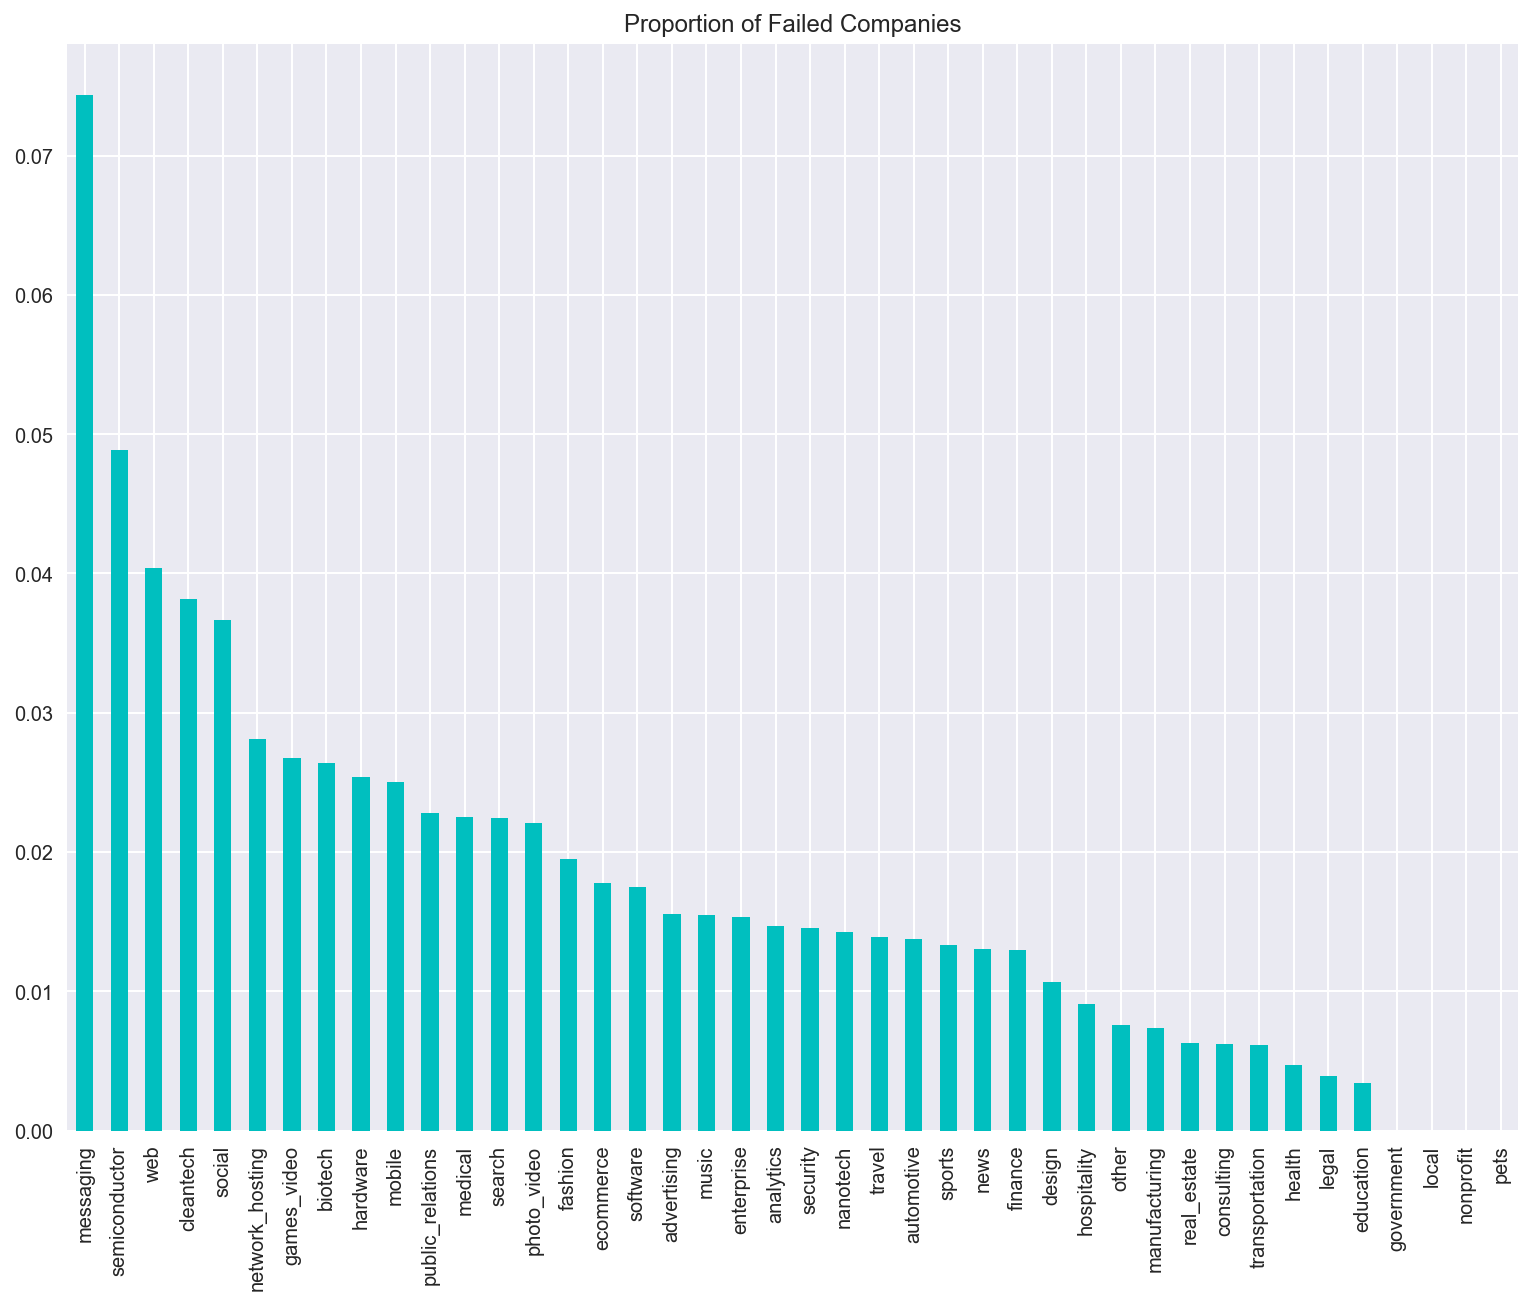

In [113]:
cls = df_objects[df_objects['status'] == 'closed'].category_code.value_counts()
ipo = df_objects[df_objects['status'] == 'ipo'].category_code.value_counts()
acq = df_objects[df_objects['status'] == 'acquired'].category_code.value_counts()
tot = df_objects.category_code.value_counts()

plt.figure(figsize=(13,10))

cls_pro = cls / tot
cls_pro.sort(ascending=0)
ax = cls_pro.iloc[:].plot(kind="bar", color='c', linewidth=20, title='Proportion of Failed Companies')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


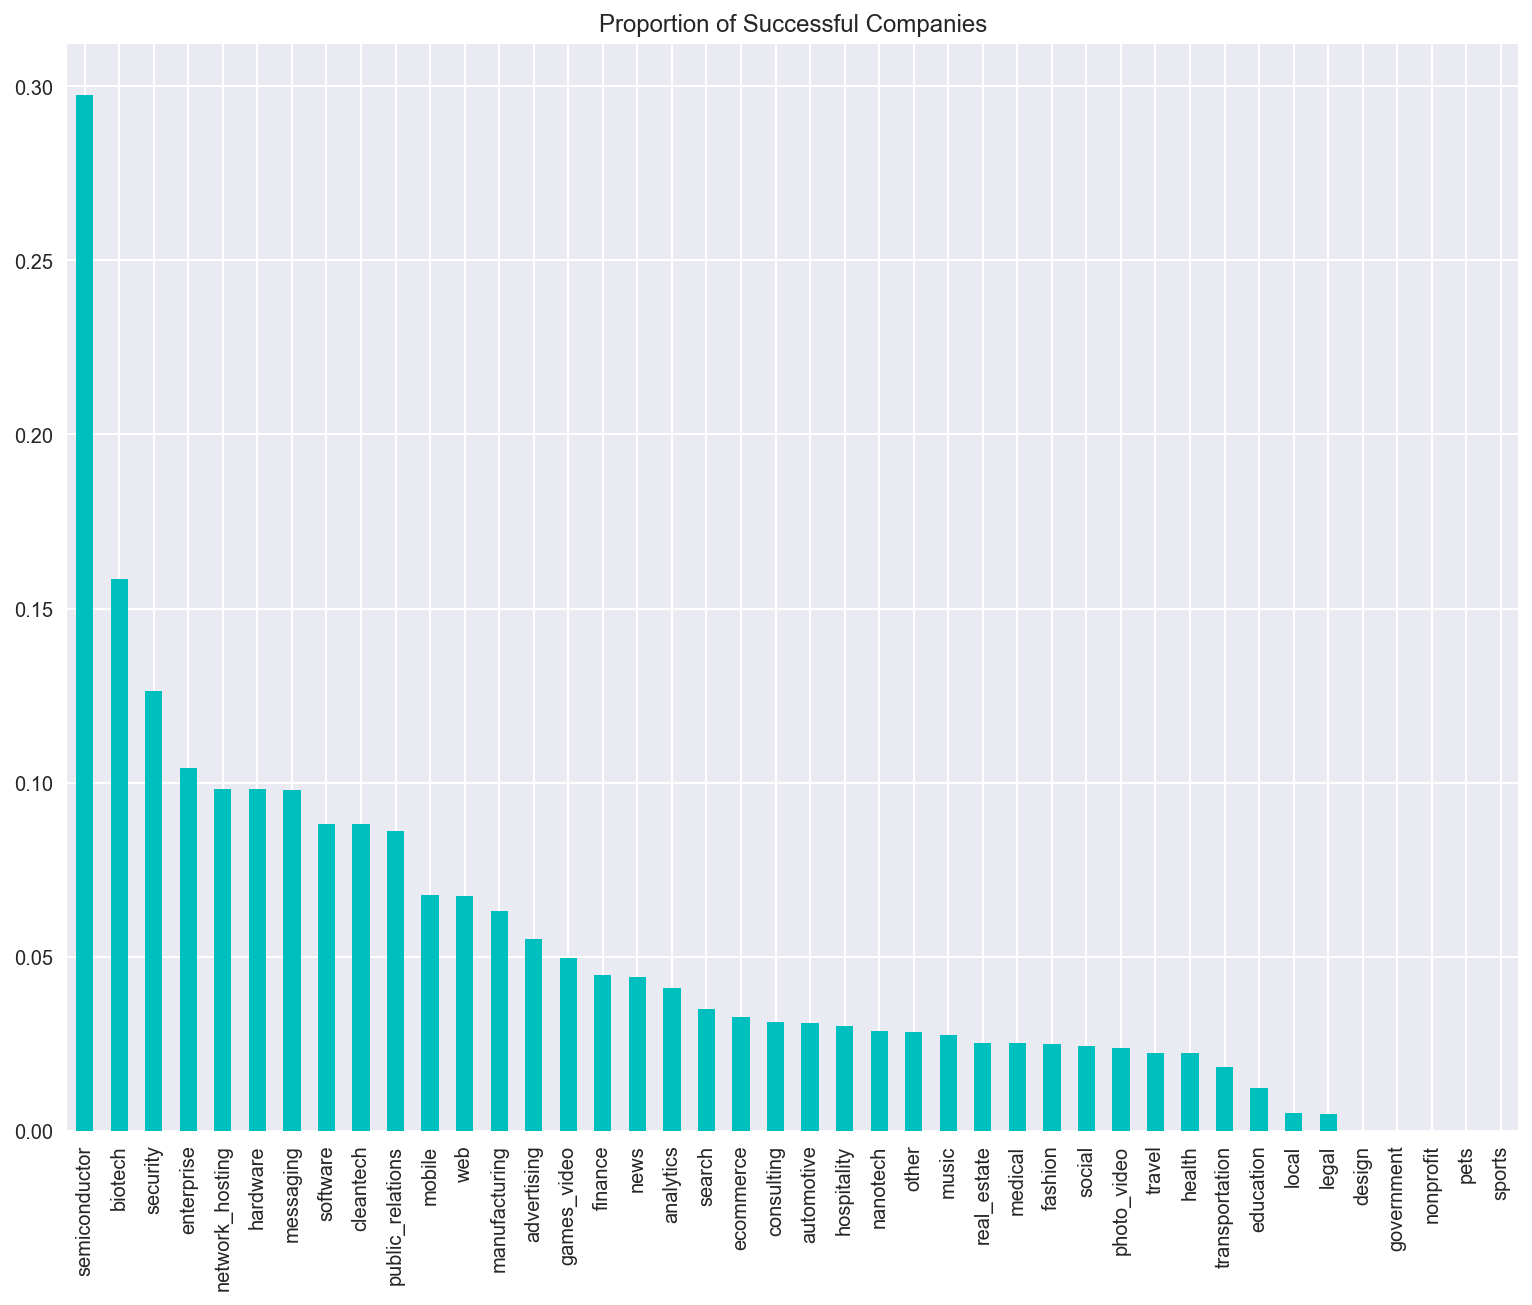

In [116]:
plt.figure(figsize=(13,10))

suc = ipo + acq

suc_pro = suc / tot
suc_pro.sort(ascending=0)
ax = suc_pro.iloc[:].plot(kind="bar", color='c', linewidth=20, title='Proportion of Successful Companies')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


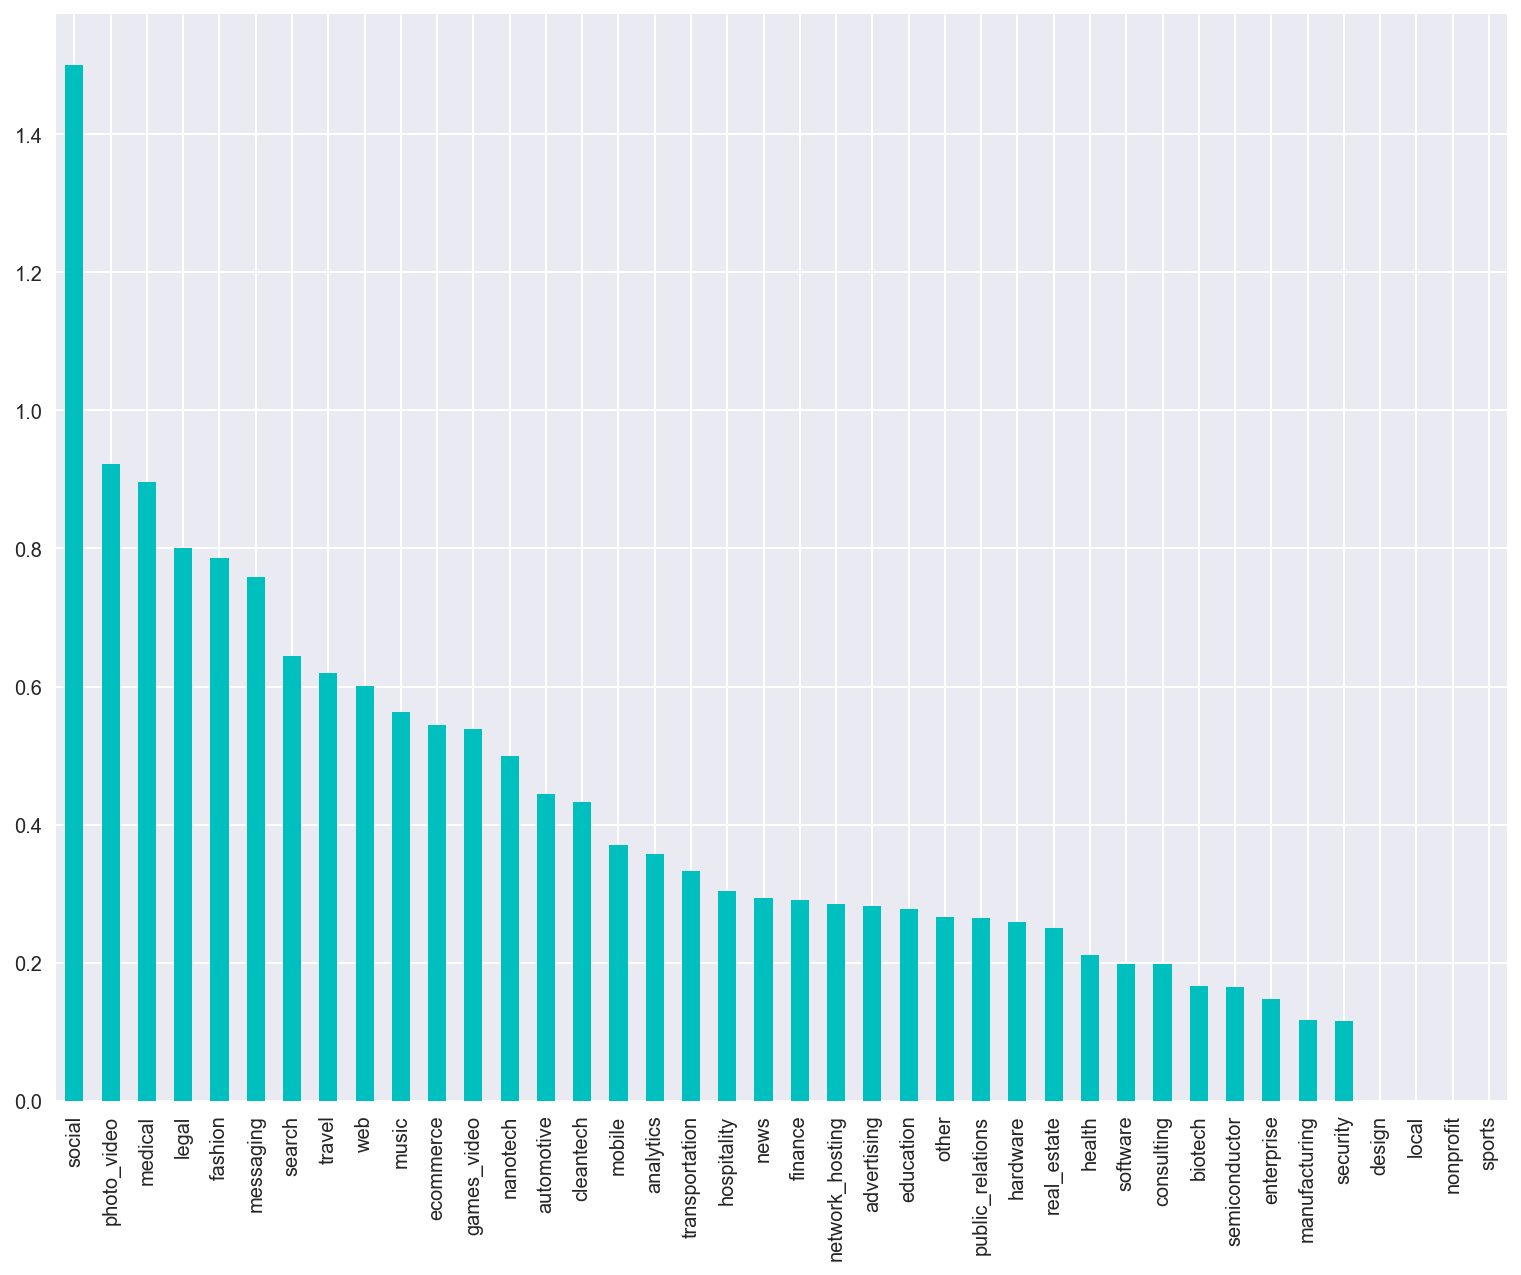

In [111]:
cls_suc = cls / suc

plt.figure(figsize=(13,10))

cls_suc.sort(ascending=0)
ax = cls_suc.iloc[:].plot(kind="bar", color='c', linewidth=20)

In [9]:
df_objects['founded_at'] = pd.to_datetime(pd.Series(df_objects['founded_at']))

In [121]:
df_objects.entity_type.value_counts()

Person          226708
Company         196553
Product          27738
FinancialOrg     11652
Name: entity_type, dtype: int64